In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from utils.plot_utils import combine_pdf_big
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
from utils.lick_utils import load_licks, load_licks_video
from utils.combine_tools import apply_qc, to_str_intlike

from open_ephys.analysis import Session
from pathlib import Path
import glob

import json
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from aind_dynamic_foraging_basic_analysis.plot.plot_foraging_session import plot_foraging_session
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from hdmf_zarr.nwb import NWBZarrIO

import pandas as pd
import pickle
import scipy.stats as stats
from joblib import Parallel, delayed
from multiprocessing import Pool
from functools import partial
import time
import shutil 
from aind_ephys_utils import align
%matplotlib inline

In [2]:
target_folder = '/root/capsule/scratch/manuscript/F_spontlicks'
video = True
if video:
    target_folder = os.path.join(target_folder, 'video')
else:
    target_folder = os.path.join(target_folder, 'beh')
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

In [3]:
dfs = [pd.read_csv('/root/capsule/code/data_management/session_assets.csv'),
        pd.read_csv('/root/capsule/code/data_management/hopkins_session_assets.csv')]
df = pd.concat(dfs)
session_list = df['session_id'].values.tolist()
ani_list = [str(session).split('_')[1] for session in session_list if str(session).startswith('behavior')]
session_list = [session for session in session_list if str(session).startswith('behavior')]
ani_session_df = pd.DataFrame({'animal': ani_list, 'session_id': session_list})


In [27]:
def analyze_animal_licks(animal_id, tb = -5, tf = 5, plot=False, video = False):
    dfs = [pd.read_csv('/root/capsule/code/data_management/session_assets.csv'),
            pd.read_csv('/root/capsule/code/data_management/hopkins_session_assets.csv')]
    df = pd.concat(dfs)
    session_list = df['session_id'].values.tolist()
    ani_list = [str(session).split('_')[1] for session in session_list if str(session).startswith('behavior')]
    session_list = [session for session in session_list if str(session).startswith('behavior')]
    ani_session_df = pd.DataFrame({'animal': ani_list, 'session_id': session_list})

    video_sessions = 0
    beh_sessions = 0

    aligned_licks = []
    in_out_mask = []
    lick_len = []
    rewarded_licks = []
    session_tbl_combined = []
    rl_ratio_out = []
    rl_ratio_in = []
    rl_ratio_outvsin = []
    rl_ratio_choice = []
    rl_ratio_in_reward_choices = []
    session_used = []
    sessions = ani_session_df[ani_session_df['animal'] == animal_id]['session_id'].values.tolist()
    if len(sessions) == 0:
        return
    for session in sessions:
        session_tbl = get_session_tbl(session)
        if session_tbl is None:
            continue
        # Concate licks
        if not video:
            licks = load_licks(session)
            beh_sessions += 1
        else:
            licks = load_licks_video(session, plot=False, inter_train_interval=1000)
            if licks is None:
                print(f'{session} has no video data, loading behavioral licks instead')
                licks = load_licks(session, plot=False, inter_train_interval=1000)
                beh_sessions += 1
            else:
                video_sessions += 1
        aligned_licks_sess = []
        in_out_mask_sess = []
        len_sess = []
        rewarded_licks_sess = []
        all_licks = licks['lick_trains_all']['train_starts']
        in_trial_session = licks['lick_trains_all']['in_trial']
        lick_len_session = licks['lick_trains_all']['train_ends'] - licks['lick_trains_all']['train_starts']
        lick_sides = licks['lick_trains_all']['side']
        for idx, row in session_tbl.iterrows():
            choice_times = row[ 'goCue_start_time']
            mask = (all_licks >= choice_times + tb) & (all_licks <= choice_times + tf)
            if idx < (len(session_tbl) - 1):
                mask &= (all_licks < session_tbl.iloc[idx+1]['goCue_start_time'] + tb)
            if idx > 0:
                mask &= (all_licks > session_tbl.iloc[idx-1]['goCue_start_time'] + tf)
            aligned_licks_trial = list(all_licks[mask] - choice_times)
            in_out_mask_trial = list(in_trial_session[mask])
            len_trial = list(lick_len_session[mask])
            aligned_licks_sess.extend(aligned_licks_trial)
            in_out_mask_sess.extend(in_out_mask_trial)
            len_sess.extend(list(lick_len_session[mask]))

            if len(aligned_licks_trial) == 0:
                continue
            rewarded_mask_trial = np.array([False]*len(aligned_licks_trial))
            if row['rewarded_historyR'] or row['rewarded_historyL']:
                rewarded_mask_trial[np.array(in_out_mask_trial)] = True
            rewarded_licks_sess.extend(list(rewarded_mask_trial))
                
        aligned_licks.append(aligned_licks_sess)
        in_out_mask.append(in_out_mask_sess)
        lick_len.append(len_sess)
        rewarded_licks.append(rewarded_licks_sess)
        # concat beh
        # for for each session, for each trial, compute: whether there's a lick train within [2.5 to 8] after go cue but before next go cue; how long has current trial been from last switch, how long until next switch
        choices_latent = session_tbl['animal_response'].values
        no_response_ind = np.where(choices_latent == 2)[0]
        no_response_ind = no_response_ind[no_response_ind > 0]
        choices_latent[no_response_ind] = choices_latent[no_response_ind - 1]
        switch_stay = choices_latent[1:] != choices_latent[:-1]
        switch_stay_pre = np.insert(switch_stay, 0, False)
        switch_stay_post = np.append(switch_stay, np.nan)
        session_tbl['switch_stay_pre'] = switch_stay_pre
        session_tbl['switch_stay_post'] = switch_stay_post
        # for each trial, compute how long since last switch
        last_switch = np.zeros(len(session_tbl))
        for i in range(1, len(session_tbl)):
            # after a switch
            if i >= np.where(switch_stay)[0][0]:
                if session_tbl.iloc[i-1]['switch_stay_post']:
                    last_switch[i] = 0
                else:
                    last_switch[i] = last_switch[i-1] + 1
            else:
                last_switch[i] = i
        session_tbl['trials_since_last_switch'] = last_switch
        # for each trial, compute how long until next switch
        next_switch = np.zeros(len(session_tbl))
        for i in range(len(session_tbl)-2, -1, -1):
            # before a switch
            if i <= np.where(switch_stay)[0][-1]:
                if session_tbl.iloc[i]['switch_stay_post']:
                    next_switch[i] = 0
                else:
                    next_switch[i] = next_switch[i+1] + 1
            else:
                next_switch[i] = np.nan
        session_tbl['trials_until_next_switch'] = next_switch
        
        # for each trial compute if there's a lick train within [2 to 8] after go cue but before next go cue
        lick_in_trial_post = np.zeros(len(session_tbl), dtype=bool)
        lick_in_trial_side = np.array([np.nan]*len(session_tbl))
        for idx, row in session_tbl.iterrows():
            align_time = row['goCue_start_time']
            mask = (all_licks >= align_time + 2) & (all_licks <= align_time + 8)
            if idx < (len(session_tbl) - 1):
                next_trial_start = session_tbl.iloc[idx+1]['goCue_start_time']
            else:
                next_trial_start = np.inf
            
            if np.sum(mask) > 0:
                lick_in_trial_post[idx] = True
            if np.all(all_licks[mask]) > next_trial_start:
                lick_in_trial_post[idx] = np.nan
            
            if lick_in_trial_post[idx]:
                lick_side_curr = lick_sides[mask]
                lick_in_trial_side[idx] = np.mean(lick_side_curr)
        session_tbl['lick_in_trial_post'] = lick_in_trial_post
        session_tbl['lick_in_trial_side_post'] = lick_in_trial_side

        # lick in following ITI
        lick_in_iti = np.zeros(len(session_tbl), dtype=bool)
        lick_in_iti_side = np.array([np.nan]*len(session_tbl))
        lick_in_iti_time = np.array([np.nan]*len(session_tbl))
        for idx, row in session_tbl.iterrows():
            align_time = row['goCue_start_time']
            if idx < (len(session_tbl) - 1):
                next_trial_start = session_tbl.iloc[idx+1]['goCue_start_time']
            else:
                next_trial_start = np.inf
            mask = (all_licks > align_time + 2) & (all_licks < next_trial_start)
            if np.sum(mask) > 0:
                lick_in_iti[idx] = True
            
            if lick_in_iti[idx]:
                lick_side_curr = lick_sides[mask]
                lick_mean = np.mean(lick_side_curr)
                lick_in_iti_side[idx] = (
                    1 if lick_mean > 0.5
                    else 0 if lick_mean < 0.5
                    else np.nan
                )
                lick_in_iti_time[idx] = all_licks[mask][0] - align_time
        
        session_tbl['lick_in_iti'] = lick_in_iti
        session_tbl['lick_in_iti_side'] = lick_in_iti_side
        session_tbl['lick_in_iti_time'] = lick_in_iti_time

        # licks before choice
        lick_in_trial_pre = np.zeros(len(session_tbl), dtype=bool)
        lick_in_trial_side_pre = np.array([np.nan]*len(session_tbl))
        for idx, row in session_tbl.iterrows():
            align_time = row['goCue_start_time']
            mask = (all_licks >= align_time - 5) & (all_licks <= align_time)
            if idx > 0:
                prev_trial_end = session_tbl.iloc[idx-1]['goCue_start_time']
            else:
                prev_trial_end = -np.inf
            
            if np.sum(mask) > 0:
                lick_in_trial_pre[idx] = True
            if np.all(all_licks[mask]) < prev_trial_end:
                lick_in_trial_pre[idx] = np.nan
            
            if lick_in_trial_pre[idx]:
                lick_side_curr = 2*(lick_sides[mask] - 0.5)
                lick_in_trial_side_pre[idx] = np.mean(lick_side_curr)
        session_tbl['lick_in_trial_pre'] = lick_in_trial_pre
        session_tbl['lick_in_trial_side_pre'] = lick_in_trial_side_pre

        session_tbl['outcome'] = session_tbl['rewarded_historyR'] | session_tbl['rewarded_historyL']
        session_tbl['outcome_pre'] = np.insert(session_tbl['outcome'].values[:-1], 0, False)
        session_tbl['choice'] = np.nan
        session_tbl.loc[session_tbl['animal_response'] == 1, 'choice'] = 1
        session_tbl.loc[session_tbl['animal_response'] == 0, 'choice'] = -1
        session_tbl['choice_pre'] = np.insert(session_tbl['choice'].values[:-1], 0, np.nan)
        session_tbl['choice_next'] = np.append(session_tbl['choice'].values[1:], np.nan)
        session_tbl['iti_length' ] = np.append(np.diff(session_tbl['goCue_start_time'].values), np.nan)

        session_tbl_combined.append(session_tbl)

        # right left ratio in out of trial licks
        rl_ratio_out_curr = (np.sum(licks['lick_trains_R']['in_trial'] == False) - np.sum(licks['lick_trains_L']['in_trial'] == False))/(np.sum(licks['lick_trains_R']['in_trial'] == False) + np.sum(licks['lick_trains_L']['in_trial'] == False))
        rl_ratio_in_choice_curr = (np.sum(session_tbl['animal_response'].values == 1) - np.sum(session_tbl['animal_response'].values == 0))/(np.sum(session_tbl['animal_response'].values == 1) + np.sum(session_tbl['animal_response'].values == 0))
        rl_ratio_in_curr = (np.sum(licks['lick_trains_R']['in_trial'] == True) - np.sum(licks['lick_trains_L']['in_trial'] == True))/(np.sum(licks['lick_trains_R']['in_trial'] == True) + np.sum(licks['lick_trains_L']['in_trial'] == True))
        reward_mask = (session_tbl['rewarded_historyR'] | session_tbl['rewarded_historyL']).values
        resp = session_tbl.loc[reward_mask, 'animal_response'].values
        rl_ratio_in_reward_choices_curr = (np.sum(resp == 1) - np.sum(resp == 0))/(np.sum(resp == 1) + np.sum(resp == 0))
        rl_ratio_out.append(rl_ratio_out_curr)
        rl_ratio_in.append(rl_ratio_in_curr)
        rl_ratio_outvsin.append(rl_ratio_out_curr - rl_ratio_in_curr)
        rl_ratio_choice.append(rl_ratio_in_choice_curr)
        rl_ratio_in_reward_choices.append(rl_ratio_in_reward_choices_curr)
        session_used.append(session)

    if len(aligned_licks) == 0:
        return
    
    # Compute session-wise statistics
    len_session_mean = [np.mean(np.array(lick_len_sess)) if len(lick_len_sess) > 0 else np.nan for lick_len_sess in lick_len]
    len_in_rwd_session_mean = [np.mean(np.array(lick_len_sess)[np.array(in_out_mask_sess) & np.array(rewarded_licks_session)]) 
                                if np.sum(np.array(in_out_mask_sess) & np.array(rewarded_licks_session)) > 0 else 0 
                                for lick_len_sess, in_out_mask_sess, rewarded_licks_session in zip(lick_len, in_out_mask, rewarded_licks)]
    len_in_no_rwd_session_mean = [np.mean(np.array(lick_len_sess)[np.array(in_out_mask_sess) & ~np.array(rewarded_licks_session)])
                                if np.sum(np.array(in_out_mask_sess) & ~np.array(rewarded_licks_session)) > 0 else 0
                                for lick_len_sess, in_out_mask_sess, rewarded_licks_session in zip(lick_len, in_out_mask, rewarded_licks)]
    len_out_session_mean = [np.mean(np.array(lick_len_sess)[~np.array(in_out_mask_sess)]) if np.sum(~np.array(in_out_mask_sess)) > 0 else 0 for lick_len_sess, in_out_mask_sess in zip(lick_len, in_out_mask)]
    
    
    count_session = [len(lick_len_sess) for lick_len_sess in lick_len]
    count_in_rwd_session = [np.sum(np.array(in_out_mask_sess) & np.array(rewarded_licks_session)) 
                            for in_out_mask_sess, rewarded_licks_session in zip(in_out_mask, rewarded_licks)]
    count_in_nrwd_session = [np.sum(np.array(in_out_mask_sess) & ~np.array(rewarded_licks_session))
                            for in_out_mask_sess, rewarded_licks_session in zip(in_out_mask, rewarded_licks)]
    count_out_session = [np.sum(~np.array(in_out_mask_sess)) for in_out_mask_sess in in_out_mask]

    quantiles = [0.25, 0.5, 0.75]
    quantiles_session = [np.quantile(np.array(lick_len_sess), quantiles) if len(lick_len_sess) > 0 else [np.nan]*len(quantiles) for lick_len_sess in lick_len]
    quantiles_in_rwd_session = [np.quantile(np.array(lick_len_sess)[np.array(in_out_mask_sess) & np.array(rewarded_licks_session)], quantiles) 
                                if np.sum(np.array(in_out_mask_sess) & np.array(rewarded_licks_session)) > 0 else [np.nan]*len(quantiles) 
                                for lick_len_sess, in_out_mask_sess, rewarded_licks_session in zip(lick_len, in_out_mask, rewarded_licks)]
    qualtiles_in_nrwd_session = [np.quantile(np.array(lick_len_sess)[np.array(in_out_mask_sess) & ~np.array(rewarded_licks_session)], quantiles)
                                if np.sum(np.array(in_out_mask_sess) & ~np.array(rewarded_licks_session)) > 0 else [np.nan]*len(quantiles)
                                for lick_len_sess, in_out_mask_sess, rewarded_licks_session in zip(lick_len, in_out_mask, rewarded_licks)]
    quantiles_out_session = [np.quantile(np.array(lick_len_sess)[~np.array(in_out_mask_sess)], quantiles) if np.sum(~np.array(in_out_mask_sess)) > 0 else [np.nan]*len(quantiles) for lick_len_sess, in_out_mask_sess in zip(lick_len, in_out_mask)]

    ratio_session = [np.mean(in_out_mask_sess) if len(lick_len_sess) > 0 else np.nan for lick_len_sess, in_out_mask_sess in zip(lick_len, in_out_mask)]
    ratio_out_session = []
    ratio_int_session = []
    for lick_len_sess, in_out_mask_sess in zip(lick_len, in_out_mask):
        if np.sum(~np.array(in_out_mask_sess)) > 0 and np.sum(np.array(in_out_mask_sess)) > 0:
            ratio_out_session.append(np.sum(~np.array(in_out_mask_sess))/len(lick_len_sess))
            ratio_int_session.append(np.sum(np.array(in_out_mask_sess))/len(lick_len_sess))
        else:
            ratio_out_session.append(np.nan)
            ratio_int_session.append(np.nan)

    # Combine all session-wise list into a big list
    lick_len = [item for sublist in lick_len for item in sublist]
    aligned_licks = [item for sublist in aligned_licks for item in sublist]
    in_out_mask = [item for sublist in in_out_mask for item in sublist]
    rewarded_licks = [item for sublist in rewarded_licks for item in sublist]

    len_mean_combined = np.mean(np.array(lick_len))
    len_mean_out_combined = np.mean(np.array(lick_len)[~np.array(in_out_mask)])
    len_mean_in_rwd_combined = np.mean(np.array(lick_len)[np.array(in_out_mask) & np.array(rewarded_licks)])
    len_mean_in_nrwd_combined = np.mean(np.array(lick_len)[np.array(in_out_mask) & ~np.array(rewarded_licks)])
    quantiles_combined = np.quantile(np.array(lick_len), quantiles)
    quantiles_out_combined = np.quantile(np.array(lick_len)[~np.array(in_out_mask)], quantiles)
    quantiles_in_rwd_combined = np.quantile(np.array(lick_len)[np.array(in_out_mask) & np.array(rewarded_licks)], quantiles)
    quantiles_in_nrwd_combined = np.quantile(np.array(lick_len)[np.array(in_out_mask) & ~np.array(rewarded_licks)], quantiles)


    # ratio of out of trial licks between right and left
     
    results = {'session_ids': session_used,
            'animal_id': animal_id,
            'all_licks': {'len_mean': len_session_mean,
                        'count': count_session,
                        'quantiles': quantiles_session},
            'in_trial_rwd_licks': {'len_mean': len_in_rwd_session_mean,
                'count': count_in_rwd_session,
                'quantiles': quantiles_in_rwd_session},
            'in_trial_no_rwd_licks': {'len_mean': len_in_no_rwd_session_mean,
                'count': count_in_nrwd_session,
                'quantiles': qualtiles_in_nrwd_session},
            'out_of_trial_licks': {'len_mean': len_out_session_mean,
                'count': count_out_session,
                'quantiles': quantiles_out_session},
            'in_out_ratio': ratio_session,
            'rl_ratio_out': rl_ratio_out,
            'rl_ratio_in': rl_ratio_in,
            'rl_ratio_outvsin': rl_ratio_outvsin,
            'rl_ratio_choice': rl_ratio_choice,
            'rl_ratio_in_reward_choices': rl_ratio_in_reward_choices,
            'combined': {'all': {'len_mean': len_mean_combined,
                                'quantiles': quantiles_combined},
                        'in_trial_rwd': {'len_mean': len_mean_in_rwd_combined,
                                        'quantiles': quantiles_in_rwd_combined},
                        'in_trial_no_rwd': {'len_mean': len_mean_in_nrwd_combined,
                                            'quantiles': quantiles_in_nrwd_combined},
                        'out_of_trial': {'len_mean': len_mean_out_combined,
                                        'quantiles': quantiles_out_combined}
                        }
            }
        
    # save combined results to pickle
    save_file = f'/root/capsule/scratch/{animal_id}/ani_combinded/lick_train_stats_video_{video}.pkl'
    with open(save_file, 'wb') as f:
        pickle.dump(results, f)

    # model
    session_tbl_combined = pd.concat(session_tbl_combined)
    # convert all boolean columns to numeric
    bool_cols = session_tbl_combined.select_dtypes(include=['bool']).columns
    session_tbl_combined[bool_cols] = session_tbl_combined[bool_cols].astype(int)

    # zscore if not only between -1 and 1
    for col in ['trials_since_last_switch', 'trials_until_next_switch']:
        session_tbl_combined[col] = session_tbl_combined[col].values/10
    
    model_post = 'lick_in_trial_post ~ trials_since_last_switch + trials_until_next_switch + outcome'
    model_pre = 'lick_in_trial_pre ~ trials_since_last_switch + trials_until_next_switch + outcome_pre'
    model_iti = 'lick_in_iti ~ trials_since_last_switch + switch_stay_post + outcome + iti_length'
    model_side_post = 'lick_in_trial_side_post ~ choice'
    model_side_pre = 'lick_in_trial_side_pre ~ choice_pre'
    model_side_iti = 'lick_in_iti_side ~ choice*lick_in_iti_time + choice + choice_next'
    
    try:
        lm_post = sm.Logit.from_formula(model_post, data=session_tbl_combined).fit()
    except:
        lm_post = None
        print(f'{session} Post model failed to fit')
    try:
        lm_pre = sm.Logit.from_formula(model_pre, data=session_tbl_combined).fit()
    except:
        lm_pre = None
        print(f'{session} Pre model failed to fit')
    try:
        lm_iti = sm.Logit.from_formula(model_iti, data=session_tbl_combined).fit()
    except:
        lm_iti = None
        print(f'{session} ITI model failed to fit')
    try:
        lm_side_post = sm.OLS.from_formula(model_side_post, data=session_tbl_combined).fit()
    except:
        lm_side_post = None
        print(f'{session} Side post model side failed to fit')
    try:
        lm_side_pre = sm.OLS.from_formula(model_side_pre, data=session_tbl_combined).fit()
    except:
        lm_side_pre = None
        print(f'{session} Side pre model side failed to fit')
    try:
        lm_side_iti = sm.Logit.from_formula(model_side_iti, data=session_tbl_combined).fit()
    except:
        lm_side_iti = None
        print(f'{session} Side iti model side failed to fit')

    # save model results to pickle
    model_results = {'lm_post': lm_post,
                    'lm_pre': lm_pre,
                    'lm_side_post': lm_side_post,
                    'lm_side_pre': lm_side_pre,
                    'lm_iti': lm_iti,
                    'lm_side_iti': lm_side_iti}
    save_file = f'/root/capsule/scratch/{animal_id}/ani_combinded/lick_in_trial_model_video_{video}.pkl'
    with open(save_file, 'wb') as f:
        pickle.dump(model_results, f)

    if plot:
        # train_lens
        fig = plt.figure(figsize=(8,4))
        gs = gridspec.GridSpec(1,2)
        # lick time
        ax1 = fig.add_subplot(gs[0, 0])
        edges = np.linspace(tb, tf, 50)
        ax1.hist(np.array(aligned_licks)[np.array(in_out_mask)], bins=edges, density=True, color='k', label='in-trial');
        ax1.hist(np.array(aligned_licks)[~np.array(in_out_mask)], bins=edges, density=True, alpha=0.5, color='gray', label='out-of-trial');
        ax1.set_title(f'Lick times aligned to choice, out = {np.sum(~np.array(in_out_mask))}, in = {np.sum(np.array(in_out_mask))}')
        ax1.set_xlabel('Time from choice (s)')
        ax1.set_ylabel('Density')
        ax1.legend()

        ax = fig.add_subplot(gs[0, 1])
        edges = np.linspace(np.min(lick_len), np.max(lick_len), 30)
        ax.hist(np.array(lick_len)[np.array(in_out_mask) & np.array(rewarded_licks)], bins=edges, color='r', label='in-trial_R', density=True);
        ax.hist(np.array(lick_len)[np.array(in_out_mask) & ~np.array(rewarded_licks)], bins=edges, color='k', label='in-trial_N', density=True);
        ax.hist(np.array(lick_len)[~np.array(in_out_mask)], bins=edges, alpha=0.5, color='gray', label='out-of-trial', density=True);
        ax.set_title('Lick train lengths')
        ax.set_xlabel('Lick train length (s)')
        ax.set_ylabel('Density')
        ax.legend()

        plt.suptitle(f'Animal {animal_id} lick statistics across {len(sessions)} sessions')
        ani_dir = f'/root/capsule/scratch/{animal_id}/ani_combinded'
        if not os.path.exists(ani_dir):
            os.makedirs(ani_dir)
        plt.tight_layout()
        fig.savefig(fname=os.path.join(ani_dir, f'lick_trains_video_{video}.pdf'), dpi=300)

        # plot model results as coefficient bar plots
        fig = plt.figure(figsize=(8,8))
        gs = gridspec.GridSpec(3, 2, hspace=0.4)
        # pre model
        if lm_pre is not None:
            ax1 = fig.add_subplot(gs[0, 0])

            z_pre   = lm_pre.tvalues[1:]
            sig_pre = lm_pre.pvalues[1:] < 0.05

            # colors per bar
            colors = ['r' if sig else 'gray' for sig in sig_pre.values]

            ax1.bar(
                z_pre.index,
                z_pre.values,
                color=colors,
                alpha=0.7,
            )

            ax1.set_title('Spont licks (pre-choice)')
            ax1.set_ylabel('z value')
            ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
        if lm_side_pre is not None:
            ax2 = fig.add_subplot(gs[0, 1])
            z_side_pre   = lm_side_pre.tvalues[1:]
            sig_side_pre = lm_side_pre.pvalues[1:] < 0.05
            # colors per bar
            colors = ['r' if sig else 'gray' for sig in sig_side_pre.values]
            ax2.bar(
                z_side_pre.index,
                z_side_pre.values,
                color=colors,
                alpha=0.7,
            )
            ax2.set_title('Spont licks side (pre-choice)')
            ax2.set_ylabel('z value')
            ax2.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
        if lm_post is not None:
            # post model
            ax3 = fig.add_subplot(gs[1, 0])
            z_post   = lm_post.tvalues[1:]
            sig_post = lm_post.pvalues[1:] < 0.05
            # colors per bar
            colors = ['r' if sig else 'gray' for sig in sig_post.values]
            ax3.bar(
                z_post.index,
                z_post.values,
                color=colors,
                alpha=0.7,
            )
            ax3.set_title('Spont licks (post-choice)')
            ax3.set_ylabel('z value')
            ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
        if lm_side_post is not None:
            ax4 = fig.add_subplot(gs[1, 1])
            z_side_post   = lm_side_post.tvalues[1:]
            sig_side_post = lm_side_post.pvalues[1:] < 0.05
            # colors per bar
            colors = ['r' if sig else 'gray' for sig in sig_side_post.values]
            ax4.bar(
                z_side_post.index,
                z_side_post.values,
                color=colors,
                alpha=0.7,
            )
            ax4.set_title('Spont licks side (post-choice)')
            ax4.set_ylabel('z value')
            ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
        if lm_iti is not None:
            ax5 = fig.add_subplot(gs[2, 0])
            z_iti   = lm_iti.tvalues[1:]
            sig_iti = lm_iti.pvalues[1:] < 0.05
            # colors per bar
            colors = ['r' if sig else 'gray' for sig in sig_iti.values]
            ax5.bar(
                z_iti.index,
                z_iti.values,
                color=colors,
                alpha=0.7,
            )
            ax5.set_title('Spont licks (ITI)')
            ax5.set_ylabel('z value')
            ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45, ha='right')
        if lm_side_iti is not None:
            ax6 = fig.add_subplot(gs[2, 1])
            z_side_iti   = lm_side_iti.tvalues[1:]
            sig_side_iti = lm_side_iti.pvalues[1:] < 0.05
            # colors per bar
            colors = ['r' if sig else 'gray' for sig in sig_side_iti.values]
            ax6.bar(
                z_side_iti.index,
                z_side_iti.values,
                color=colors,
                alpha=0.7,
            )
            ax6.set_title('Spont licks side (ITI)')
            ax6.set_ylabel('z value')
            ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45, ha='right')
            

        plt.suptitle(f'Animal {animal_id} lick across {beh_sessions} behavior and {video_sessions} video sessions')
        plt.tight_layout()
        fig.savefig(fname=os.path.join(ani_dir, f'lick_in_trial_model_coefficients_video_{video}.pdf'), dpi=300)


In [28]:
analyze_animal_licks(animal_id='791691', video=True, plot=False)

Lick video file not found for session behavior_791691_2025-06-24_13-21-29. Please run the lick video processing pipeline first.
behavior_791691_2025-06-24_13-21-29 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_791691_2025-06-26_13-39-26. Please run the lick video processing pipeline first.
behavior_791691_2025-06-26_13-39-26 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.486886
         Iterations 6
         Current function value: 0.002709
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.667123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.563628
         Iterations 5


In [19]:
load_file = f'/root/capsule/scratch/791691/ani_combinded/lick_train_stats_video_{video}.pkl'
with open(load_file, 'rb') as f:
    results = pickle.load(f)

In [29]:
from joblib import Parallel, delayed

animal_ids = ani_session_df['animal'].unique().tolist()

results = Parallel(n_jobs=-1)(
    delayed(analyze_animal_licks)(animal_id, plot=False, video=True)
    for animal_id in animal_ids
)


Lick video file not found for session behavior_751004_2024-12-19_11-50-37. Please run the lick video processing pipeline first.
behavior_751004_2024-12-19_11-50-37 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_722832_2024-09-13_11-55-58. Please run the lick video processing pipeline first.
behavior_722832_2024-09-13_11-55-58 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_739970_2024-10-15_10-04-12. Please run the lick video processing pipeline first.
behavior_739970_2024-10-15_10-04-12 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_758017_2025-02-04_11-57-38. Please run the lick video processing pipeline first.
behavior_758017_2025-02-04_11-57-38 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_717259_2024-06-25_10-09-25. Please run the lick video processing pipeline first.
behavior_717259_2024-06-25_10-09-25 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_716325_2024-05-29_10-33-32. Please run the lick video processing pipeline first.
behavior

/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_717263_2024-07-23_11-46-42. Please run the lick video processing pipeline first.
behavior_717263_2024-07-23_11-46-42 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_717121_2024-06-11_10-23-31. Please run the lick video processing pipeline first.
behavior_717121_2024-06-11_10-23-31 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_739977_2024-10-24_12-58-26. Please run the lick video processing pipeline first.
behavior_739977_2024-10-24_12-58-26 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_714116_2024-08-27_11-29-48. Please run the lick video processing pipeline first.
behavior_714116_2024-08-27_11-29-48 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.450771
         Iterations 6
         Current function value: 0.010921
         Iterations: 35
behavior_722832_2024-09-13_11-55-58 Pre model failed to fit
Optimization terminated successfully.
         Current function value: 0.226725
         Iterations 7
         Current function value: 0.274971
         Iterations: 35


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _method

Optimization terminated successfully.
         Current function value: 0.556895
         Iterations 5
         Current function value: 0.017344
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.427405
         Iterations 7
         Current function value: 0.523931
         Iterations: 35
behavior_739977_2024-10-24_12-58-26 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_724172_2024-10-01_11-20-11. Please run the lick video processing pipeline first.
behavior_724172_2024-10-01_11-20-11 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_752014_2025-03-25_12-09-20. Please run the lick video processing pipeline first.
behavior_752014_2025-03-25_12-09-20 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_751181_2025-02-26_11-51-19. Please run the lick video processing pipeline first.
behavior_751181_2025-02-26_11-51-19 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_739970_2024-10-16_12-15-24. Please run the lick video processing pipeline first.
behavior_739970_2024-10-16_12-15-24 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_717121_2024-06-13_12-21-20. Please run the lick video processing pipeline first.
behavior_717121_2024-06-13_12-21-20 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_717259_2024-06-26_10-23-07. Please run the lick video processing pipeline first.
behavior_717259_2024-06-26_10-23-07 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_717263_2024-07-24_10-40-05. Please run the lick video processing pipeline first.
behavior_717263_2024-07-24_10-40-05 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_714116_2024-08-28_12-11-55. Please run the lick video processing pipeline first.
behavior_714116_2024-08-28_12-11-55 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.606524
         Iterations 5
         Current function value: 0.006788
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.092961
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.560290
         Iterations 6


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_724172_2024-10-03_11-02-53. Please run the lick video processing pipeline first.
behavior_724172_2024-10-03_11-02-53 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.597036
         Iterations 5
         Current function value: 0.006710
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.379304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496814
         Iterations 6


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_754897_2025-03-13_11-20-42. Please run the lick video processing pipeline first.
behavior_754897_2025-03-13_11-20-42 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.663094
         Iterations 4
         Current function value: 0.015887
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.439617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.594265
         Iterations 6


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.628187
         Iterations 5
         Current function value: 0.011620
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.512608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.670501
         Iterations 5


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_717121_2024-06-14_10-23-49. Please run the lick video processing pipeline first.
behavior_717121_2024-06-14_10-23-49 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_714116_2024-08-29_11-46-43. Please run the lick video processing pipeline first.
behavior_714116_2024-08-29_11-46-43 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.611164
         Iterations 5
         Current function value: 0.009467
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.330000
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.633731
         Iterations 5


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_717259_2024-06-28_11-17-19. Please run the lick video processing pipeline first.
behavior_717259_2024-06-28_11-17-19 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_717263_2024-07-25_10-02-21. Please run the lick video processing pipeline first.
behavior_717263_2024-07-25_10-02-21 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.523501
         Iterations 6
         Current function value: 0.015910
         Iterations: 35
behavior_714116_2024-08-29_11-46-43 Pre model failed to fit
Optimization terminated successfully.
         Current function value: 0.394725
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.615533
         Iterations 5


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.661735
         Iterations 4
         Current function value: 0.012795
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.341788
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.301162
         Iterations 29
behavior_717263_2024-07-25_10-02-21 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.614182
         Iterations 6
         Current function value: 0.006543
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.395552
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.670692
         Iterations 5
Lick video file not found for session behavior_ZS059_2021-03-24_14-22-04. Please run the lick video processing pipeline first.
behavior_ZS059_2021-03-24_14-22-04 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.522645
         Iterations 5
         Current function value: 0.008624
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.528856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679949
         Iterations 4
Lick video file not found for session behavior_791691_2025-06-24_13-21-29. Please run the lick video processing pipeline first.
behavior_791691_2025-06-24_13-21-29 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS060_2021-03-20_16-20-00. Please run the lick video processing pipeline first.
behavior_ZS060_2021-03-20_16-20-00 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_716325_2024-06-01_09-25-37. Please run the lick video processing pipeline first.
behavior_716325_2024-06-01_09-25-37 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS059_2021-03-25_14-40-45. Please run the lick video processing pipeline first.
behavior_ZS059_2021-03-25_14-40-45 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_781166_2025-05-13_14-04-27. Please run the lick video processing pipeline first.
behavior_781166_2025-05-13_14-04-27 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_785956_2025-05-20_14-15-19. Please run the lick video processing pipeline first.
behavior_785956_2025-05-20_14-15-19 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Optimization terminated successfully.
         Current function value: 0.662461
         Iterations 5
         Current function value: 0.008460
         Iterations: 35
behavior_758017_2025-02-07_14-11-08 Pre model failed to fit
Optimization terminated successfully.
         Current function value: 0.237417
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.591362
         Iterations 6


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: 0.481372
         Iterations 7
         Current function value: inf
         Iterations: 35
behavior_716325_2024-06-01_09-25-37 Pre model failed to fit
Optimization terminated successfully.
         Current function value: 0.538532
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.569514
         Iterations 5


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS061_2021-03-16_15-30-00. Please run the lick video processing pipeline first.
behavior_ZS061_2021-03-16_15-30-00 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-03-24_18-52-34. Please run the lick video processing pipeline first.
behavior_ZS062_2021-03-24_18-52-34 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_763590_2025-05-02_11-07-09. Please run the lick video processing pipeline first.
behavior_763590_2025-05-02_11-07-09 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS060_2021-03-21_16-15-00. Please run the lick video processing pipeline first.
behavior_ZS060_2021-03-21_16-15-00 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_717121_2024-06-15_10-00-58. Please run the lick video processing pipeline first.
behavior_717121_2024-06-15_10-00-58 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.613316
         Iterations 5
         Current function value: 0.007765
         Iterations: 35
behavior_751004_2024-12-23_14-20-03 Pre model failed to fit
Optimization terminated successfully.
         Current function value: 0.544332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488592
         Iterations 6


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Optimization terminated successfully.
         Current function value: 0.625524
         Iterations 5
         Current function value: 0.010279
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.190609
         Iterations 8
         Current function value: 0.522818
         Iterations: 35


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: 

Lick video file not found for session behavior_ZS059_2021-03-26_13-52-11. Please run the lick video processing pipeline first.
behavior_ZS059_2021-03-26_13-52-11 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.642753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617229
         Iterations 5
         Current function value: 0.004959
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.307946
         Iterations 8
         Current function value: 0.010188
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.387342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.664834
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.621023
         Iterations 6
Lick video file not found for session behavior_791691_2025-06-26_13-39-26. Please run the lick video processing pipeline first.
behavior_791691_2025-06-26_13-39-26 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-03-17_16-00-53. Please run the lick video processing pipeline first.
behavior_ZS061_2021-03-17_16-00-53 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS062_2021-03-25_18-44-20. Please run the lick video processing pipeline first.
behavior_ZS062_2021-03-25_18-44-20 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS060_2021-03-22_16-25-00. Please run the lick video processing pipeline first.
behavior_ZS060_2021-03-22_16-25-00 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_785956_2025-05-21_13-42-02. Please run the lick video processing pipeline first.
behavior_785956_2025-05-21_13-42-02 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_781166_2025-05-14_14-18-28. Please run the lick video processing pipeline first.
behavior_781166_2025-05-14_14-18-28 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.373964
         Iterations 6
         Current function value: 0.011905
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.473359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638551
         Iterations 5


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_717121_2024-06-16_11-45-02. Please run the lick video processing pipeline first.
behavior_717121_2024-06-16_11-45-02 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS059_2021-03-27_16-03-00. Please run the lick video processing pipeline first.
behavior_ZS059_2021-03-27_16-03-00 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS061_2021-03-18_17-39-19. Please run the lick video processing pipeline first.
behavior_ZS061_2021-03-18_17-39-19 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-03-26_18-45-54. Please run the lick video processing pipeline first.
behavior_ZS062_2021-03-26_18-45-54 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Optimization terminated successfully.
         Current function value: 0.486886
         Iterations 6
         Current function value: 0.002709
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.667123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.563628
         Iterations 5


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Optimization terminated successfully.
         Current function value: 0.658226
         Iterations 5
         Current function value: 0.007938
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.238226
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.676701
         Iterations 6


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Optimization terminated successfully.
         Current function value: 0.547610
         Iterations 6
         Current function value: 0.014602
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.504239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.584412
         Iterations 6
Lick video file not found for session behavior_ZS060_2021-03-23_15-15-00. Please run the lick video processing pipeline first.
behavior_ZS060_2021-03-23_15-15-00 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _method

Lick video file not found for session behavior_785956_2025-05-23_13-45-21. Please run the lick video processing pipeline first.
behavior_785956_2025-05-23_13-45-21 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Optimization terminated successfully.
         Current function value: 0.647713
         Iterations 5
         Current function value: 0.008579
         Iterations: 35
behavior_782394_2025-04-25_11-13-21 Pre model failed to fit
Optimization terminated successfully.
         Current function value: 0.256343
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.584536
         Iterations 5


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_781166_2025-05-15_14-20-51. Please run the lick video processing pipeline first.
behavior_781166_2025-05-15_14-20-51 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS059_2021-03-28_14-18-58. Please run the lick video processing pipeline first.
behavior_ZS059_2021-03-28_14-18-58 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.668070
         Iterations 4
         Current function value: 0.010469
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.155440
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.581337
         Iterations 6


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-03-19_17-52-45. Please run the lick video processing pipeline first.
behavior_ZS061_2021-03-19_17-52-45 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-03-27_19-15-29. Please run the lick video processing pipeline first.
behavior_ZS062_2021-03-27_19-15-29 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS060_2021-03-24_15-40-00. Please run the lick video processing pipeline first.
behavior_ZS060_2021-03-24_15-40-00 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_781166_2025-05-16_14-16-34. Please run the lick video processing pipeline first.
behavior_781166_2025-05-16_14-16-34 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS059_2021-03-29_14-41-57. Please run the lick video processing pipeline first.
behavior_ZS059_2021-03-29_14-41-57 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.635975
         Iterations 5
         Current function value: inf
         Iterations: 35
behavior_781166_2025-05-16_14-16-34 Pre model failed to fit
Optimization terminated successfully.
         Current function value: 0.094584
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.647429
         Iterations 5


/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-03-20_18-03-26. Please run the lick video processing pipeline first.
behavior_ZS061_2021-03-20_18-03-26 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-03-28_17-40-42. Please run the lick video processing pipeline first.
behavior_ZS062_2021-03-28_17-40-42 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS060_2021-03-25_16-00-00. Please run the lick video processing pipeline first.
behavior_ZS060_2021-03-25_16-00-00 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS059_2021-03-30_14-57-13. Please run the lick video processing pipeline first.
behavior_ZS059_2021-03-30_14-57-13 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS061_2021-03-21_17-37-00. Please run the lick video processing pipeline first.
behavior_ZS061_2021-03-21_17-37-00 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-03-29_18-50-00. Please run the lick video processing pipeline first.
behavior_ZS062_2021-03-29_18-50-00 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS060_2021-03-26_14-50-00. Please run the lick video processing pipeline first.
behavior_ZS060_2021-03-26_14-50-00 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS059_2021-03-31_14-32-51. Please run the lick video processing pipeline first.
behavior_ZS059_2021-03-31_14-32-51 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.234277
         Iterations 7
         Current function value: inf
         Iterations: 35
behavior_784803_2025-07-03_13-55-13 Pre model failed to fit
Optimization terminated successfully.
         Current function value: 0.490417
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.679270
         Iterations 4


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No raw session directory found for behavior_ZS062_2021-03-30_18-30-24.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-03-22_17-35-53. Please run the lick video processing pipeline first.
behavior_ZS061_2021-03-22_17-35-53 has no video data, loading behavioral licks instead
No raw session directory found for behavior_ZS062_2021-03-30_18-30-24.
No raw session directory found for behavior_ZS062_2021-03-30_18-30-24.
Lick video file not found for session behavior_ZS062_2021-03-30_18-30-24. Please run the lick video processing pipeline first.
behavior_ZS062_2021-03-30_18-30-24 has no video data, loading behavioral licks instead
No raw session directory found for behavior_ZS062_2021-03-30_18-30-24.
Lick video file not found for session behavior_ZS060_2021-03-27_17-11-43. Please run the lick video processing pipeline first.
behavior_ZS060_2021-03-27_17-11-43 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No raw session directory found for behavior_ZS062_2021-03-30_18-30-24.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS059_2021-04-01_14-17-46. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-01_14-17-46 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS061_2021-03-23_16-08-12. Please run the lick video processing pipeline first.
behavior_ZS061_2021-03-23_16-08-12 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS062_2021-03-31_18-40-52. Please run the lick video processing pipeline first.
behavior_ZS062_2021-03-31_18-40-52 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS060_2021-03-28_15-27-56. Please run the lick video processing pipeline first.
behavior_ZS060_2021-03-28_15-27-56 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS059_2021-04-02_15-05-16. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-02_15-05-16 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-04-01_17-49-36. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-01_17-49-36 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS061_2021-03-24_17-24-09. Please run the lick video processing pipeline first.
behavior_ZS061_2021-03-24_17-24-09 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS060_2021-03-29_16-21-37. Please run the lick video processing pipeline first.
behavior_ZS060_2021-03-29_16-21-37 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS059_2021-04-03_16-30-45. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-03_16-30-45 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-04-02_19-08-52. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-02_19-08-52 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS060_2021-03-30_16-13-03. Please run the lick video processing pipeline first.
behavior_ZS060_2021-03-30_16-13-03 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS061_2021-03-25_17-12-27. Please run the lick video processing pipeline first.
behavior_ZS061_2021-03-25_17-12-27 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS059_2021-04-04_15-23-14. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-04_15-23-14 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS060_2021-03-31_15-45-00. Please run the lick video processing pipeline first.
behavior_ZS060_2021-03-31_15-45-00 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS062_2021-04-03_20-26-34. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-03_20-26-34 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS061_2021-03-26_17-28-33. Please run the lick video processing pipeline first.
behavior_ZS061_2021-03-26_17-28-33 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS059_2021-04-05_14-33-48. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-05_14-33-48 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-04-04_18-59-47. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-04_18-59-47 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS060_2021-04-01_15-30-00. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-01_15-30-00 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS061_2021-03-27_18-20-45. Please run the lick video processing pipeline first.
behavior_ZS061_2021-03-27_18-20-45 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS059_2021-04-06_14-30-26. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-06_14-30-26 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-04-05_19-25-39. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-05_19-25-39 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS060_2021-04-02_16-30-00. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-02_16-30-00 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS061_2021-03-28_16-35-51. Please run the lick video processing pipeline first.
behavior_ZS061_2021-03-28_16-35-51 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS059_2021-04-07_13-58-21. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-07_13-58-21 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-04-06_18-46-42. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-06_18-46-42 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS060_2021-04-03_17-45-00. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-03_17-45-00 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS061_2021-03-29_17-48-18. Please run the lick video processing pipeline first.
behavior_ZS061_2021-03-29_17-48-18 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS059_2021-04-08_15-53-36. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-08_15-53-36 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-04-07_17-58-07. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-07_17-58-07 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS060_2021-04-04_16-30-00. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-04_16-30-00 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-03-30_16-57-26. Please run the lick video processing pipeline first.
behavior_ZS061_2021-03-30_16-57-26 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS059_2021-04-09_15-53-45. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-09_15-53-45 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-04-08_19-07-10. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-08_19-07-10 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS060_2021-04-07_15-21-40. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-07_15-21-40 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-03-31_17-15-48. Please run the lick video processing pipeline first.
behavior_ZS061_2021-03-31_17-15-48 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS059_2021-04-10_15-55-11. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-10_15-55-11 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS060_2021-04-08_16-55-35. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-08_16-55-35 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS062_2021-04-09_19-27-26. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-09_19-27-26 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-04-01_16-38-03. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-01_16-38-03 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS059_2021-04-11_15-41-45. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-11_15-41-45 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-04-10_19-16-30. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-10_19-16-30 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS060_2021-04-09_17-07-51. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-09_17-07-51 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-04-02_17-53-41. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-02_17-53-41 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS059_2021-04-12_14-57-43. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-12_14-57-43 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

No raw session directory found for behavior_ZS060_2021-04-10_16-58-41.
No raw session directory found for behavior_ZS060_2021-04-10_16-58-41.
No raw session directory found for behavior_ZS060_2021-04-10_16-58-41.
Lick video file not found for session behavior_ZS060_2021-04-10_16-58-41. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-10_16-58-41 has no video data, loading behavioral licks instead
No raw session directory found for behavior_ZS060_2021-04-10_16-58-41.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-04-11_18-58-53. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-11_18-58-53 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No raw session directory found for behavior_ZS061_2021-04-03_18-50-29.
No raw session directory found for behavior_ZS061_2021-04-03_18-50-29.
No raw session directory found for behavior_ZS061_2021-04-03_18-50-29.
Lick video file not found for session behavior_ZS061_2021-04-03_18-50-29. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-03_18-50-29 has no video data, loading behavioral licks instead
No raw session directory found for behavior_ZS061_2021-04-03_18-50-29.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No raw session directory found for behavior_ZS060_2021-04-10_16-58-41.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS059_2021-04-13_15-43-53. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-13_15-43-53 has no video data, loading behavioral licks instead
No raw session directory found for behavior_ZS061_2021-04-03_18-50-29.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

No raw session directory found for behavior_ZS060_2021-04-11_16-41-30.
No raw session directory found for behavior_ZS060_2021-04-11_16-41-30.
No raw session directory found for behavior_ZS060_2021-04-11_16-41-30.
Lick video file not found for session behavior_ZS060_2021-04-11_16-41-30. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-11_16-41-30 has no video data, loading behavioral licks instead
No raw session directory found for behavior_ZS060_2021-04-11_16-41-30.
Lick video file not found for session behavior_ZS062_2021-04-12_18-46-29. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-12_18-46-29 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No raw session directory found for behavior_ZS060_2021-04-11_16-41-30.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-04-04_17-43-18. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-04_17-43-18 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS059_2021-04-14_14-51-04. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-14_14-51-04 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

No raw session directory found for behavior_ZS060_2021-04-12_15-57-59.
No raw session directory found for behavior_ZS060_2021-04-12_15-57-59.
No raw session directory found for behavior_ZS060_2021-04-12_15-57-59.
Lick video file not found for session behavior_ZS062_2021-04-13_19-35-13. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-13_19-35-13 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS060_2021-04-12_15-57-59. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-12_15-57-59 has no video data, loading behavioral licks instead
No raw session directory found for behavior_ZS060_2021-04-12_15-57-59.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No raw session directory found for behavior_ZS060_2021-04-12_15-57-59.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-04-05_18-01-32. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-05_18-01-32 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS059_2021-04-15_15-29-28. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-15_15-29-28 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

No raw session directory found for behavior_ZS060_2021-04-14_18-15-27.
No raw session directory found for behavior_ZS060_2021-04-14_18-15-27.
No raw session directory found for behavior_ZS060_2021-04-14_18-15-27.
Lick video file not found for session behavior_ZS060_2021-04-14_18-15-27. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-14_18-15-27 has no video data, loading behavioral licks instead
No raw session directory found for behavior_ZS060_2021-04-14_18-15-27.
Lick video file not found for session behavior_ZS062_2021-04-14_17-07-51. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-14_17-07-51 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No raw session directory found for behavior_ZS060_2021-04-14_18-15-27.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-04-06_16-13-38. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-06_16-13-38 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS059_2021-04-16_14-50-15. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-16_14-50-15 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-04-15_17-52-49. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-15_17-52-49 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS060_2021-04-15_19-06-02. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-15_19-06-02 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS061_2021-04-07_16-47-22. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-07_16-47-22 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS059_2021-04-17_15-44-53. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-17_15-44-53 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-04-16_18-17-09. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-16_18-17-09 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS060_2021-04-16_16-09-11. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-16_16-09-11 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

No raw session directory found for behavior_ZS059_2021-04-18_17-26-19.
Lick video file not found for session behavior_ZS061_2021-04-08_18-01-30. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-08_18-01-30 has no video data, loading behavioral licks instead
No raw session directory found for behavior_ZS059_2021-04-18_17-26-19.
No raw session directory found for behavior_ZS059_2021-04-18_17-26-19.
Lick video file not found for session behavior_ZS059_2021-04-18_17-26-19. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-18_17-26-19 has no video data, loading behavioral licks instead
No raw session directory found for behavior_ZS059_2021-04-18_17-26-19.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

No raw session directory found for behavior_ZS060_2021-04-21_19-23-52.
Lick video file not found for session behavior_ZS062_2021-04-17_18-06-40. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-17_18-06-40 has no video data, loading behavioral licks instead
No raw session directory found for behavior_ZS059_2021-04-18_17-26-19.
No raw session directory found for behavior_ZS060_2021-04-21_19-23-52.
No raw session directory found for behavior_ZS060_2021-04-21_19-23-52.
Lick video file not found for session behavior_ZS060_2021-04-21_19-23-52. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-21_19-23-52 has no video data, loading behavioral licks instead
No raw session directory found for behavior_ZS060_2021-04-21_19-23-52.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No raw session directory found for behavior_ZS060_2021-04-21_19-23-52.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-04-09_18-19-29. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-09_18-19-29 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS059_2021-04-19_14-42-16. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-19_14-42-16 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-04-18_19-52-39. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-18_19-52-39 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS060_2021-04-22_18-30-00. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-22_18-30-00 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS059_2021-04-20_14-50-03. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-20_14-50-03 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS061_2021-04-10_18-01-14. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-10_18-01-14 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-04-19_19-36-48. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-19_19-36-48 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS060_2021-04-23_18-34-53. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-23_18-34-53 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS059_2021-04-21_15-58-55. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-21_15-58-55 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-04-11_17-44-56. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-11_17-44-56 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS062_2021-04-20_18-23-52. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-20_18-23-52 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS060_2021-04-24_18-50-00. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-24_18-50-00 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS059_2021-04-22_15-11-25. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-22_15-11-25 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-04-12_17-26-54. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-12_17-26-54 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-04-21_18-15-30. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-21_18-15-30 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS060_2021-04-25_19-51-06. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-25_19-51-06 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS059_2021-04-23_14-57-50. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-23_14-57-50 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-04-13_18-14-05. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-13_18-14-05 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-04-22_17-18-06. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-22_17-18-06 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS060_2021-04-26_19-24-52. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-26_19-24-52 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS059_2021-04-24_15-38-10. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-24_15-38-10 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-04-14_16-04-22. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-14_16-04-22 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-04-23_17-27-03. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-23_17-27-03 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No raw session directory found for behavior_ZS060_2021-04-27_16-21-43.
No raw session directory found for behavior_ZS060_2021-04-27_16-21-43.
No raw session directory found for behavior_ZS060_2021-04-27_16-21-43.
Lick video file not found for session behavior_ZS060_2021-04-27_16-21-43. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-27_16-21-43 has no video data, loading behavioral licks instead
No raw session directory found for behavior_ZS060_2021-04-27_16-21-43.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

No raw session directory found for behavior_ZS060_2021-04-27_16-21-43.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS059_2021-04-25_16-22-31. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-25_16-22-31 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-04-15_16-45-44. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-15_16-45-44 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS062_2021-04-24_17-54-39. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-24_17-54-39 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS060_2021-04-28_15-16-45. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-28_15-16-45 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS059_2021-04-26_14-44-03. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-26_14-44-03 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-04-16_17-08-59. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-16_17-08-59 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS062_2021-04-25_18-53-35. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-25_18-53-35 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS060_2021-04-29_15-15-00. Please run the lick video processing pipeline first.
behavior_ZS060_2021-04-29_15-15-00 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS059_2021-04-27_15-12-43. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-27_15-12-43 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-04-17_16-50-25. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-17_16-50-25 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS062_2021-04-26_20-26-29. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-26_20-26-29 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.576686
         Iterations 5
         Current function value: 0.009941
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.437491
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687811
         Iterations 5


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS059_2021-04-28_14-00-12. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-28_14-00-12 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS061_2021-04-18_18-32-58. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-18_18-32-58 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS062_2021-04-27_19-23-36. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-27_19-23-36 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS059_2021-04-29_14-02-45. Please run the lick video processing pipeline first.
behavior_ZS059_2021-04-29_14-02-45 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS061_2021-04-19_18-31-40. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-19_18-31-40 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS062_2021-04-28_17-53-01. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-28_17-53-01 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.482331
         Iterations 6
         Current function value: 0.013630
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.532208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.671063
         Iterations 4


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-04-20_15-49-57. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-20_15-49-57 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS062_2021-04-29_17-36-37. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-29_17-36-37 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-04-30_18-11-39. Please run the lick video processing pipeline first.
behavior_ZS062_2021-04-30_18-11-39 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS061_2021-04-21_17-03-09. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-21_17-03-09 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-05-01_19-48-01. Please run the lick video processing pipeline first.
behavior_ZS062_2021-05-01_19-48-01 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS061_2021-04-22_16-25-00. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-22_16-25-00 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-05-02_19-20-50. Please run the lick video processing pipeline first.
behavior_ZS062_2021-05-02_19-20-50 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS061_2021-04-23_16-13-13. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-23_16-13-13 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-05-03_13-58-20. Please run the lick video processing pipeline first.
behavior_ZS062_2021-05-03_13-58-20 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS061_2021-04-24_16-48-52. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-24_16-48-52 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-05-04_14-29-20. Please run the lick video processing pipeline first.
behavior_ZS062_2021-05-04_14-29-20 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS061_2021-04-25_17-45-36. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-25_17-45-36 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-05-05_16-34-46. Please run the lick video processing pipeline first.
behavior_ZS062_2021-05-05_16-34-46 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-04-26_18-08-01. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-26_18-08-01 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-05-06_15-46-14. Please run the lick video processing pipeline first.
behavior_ZS062_2021-05-06_15-46-14 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS061_2021-04-27_18-19-52. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-27_18-19-52 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-05-07_17-38-21. Please run the lick video processing pipeline first.
behavior_ZS062_2021-05-07_17-38-21 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS061_2021-04-28_16-35-50. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-28_16-35-50 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-05-08_18-43-47. Please run the lick video processing pipeline first.
behavior_ZS062_2021-05-08_18-43-47 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS061_2021-04-29_16-18-51. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-29_16-18-51 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-05-09_17-15-10. Please run the lick video processing pipeline first.
behavior_ZS062_2021-05-09_17-15-10 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS061_2021-04-30_17-06-18. Please run the lick video processing pipeline first.
behavior_ZS061_2021-04-30_17-06-18 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-05-10_19-15-51. Please run the lick video processing pipeline first.
behavior_ZS062_2021-05-10_19-15-51 has no video data, loading behavioral licks instead
Lick video file not found for session behavior_ZS061_2021-05-01_18-28-14. Please run the lick video processing pipeline first.
behavior_ZS061_2021-05-01_18-28-14 has no video data, loading behavioral licks instead


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-05-11_20-10-59. Please run the lick video processing pipeline first.
behavior_ZS062_2021-05-11_20-10-59 has no video data, loading behavioral licks instead
Optimization terminated successfully.
         Current function value: 0.639130
         Iterations 5
         Current function value: 0.012345
         Iterations: 35
behavior_ZS061_2021-05-01_18-28-14 Pre model failed to fit
Optimization terminated successfully.
         Current function value: 0.286709
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.673704
         Iterations 4


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Optimization terminated successfully.
         Current function value: 0.583303
         Iterations 5
         Current function value: inf
         Iterations: 35
behavior_ZS062_2021-05-11_20-10-59 Pre model failed to fit
Optimization terminated successfully.
         Current function value: 0.443354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692269
         Iterations 4


/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


In [30]:
# load data from all animals and plot summary statistics
animal_ids = ani_session_df['animal'].unique().tolist()
all_results = []
all_results_model = []
for animal_id in animal_ids:
    save_file = f'/root/capsule/scratch/{animal_id}/ani_combinded/lick_train_stats_video_{video}.pkl' 
    if os.path.exists(save_file):
        with open(save_file, 'rb') as f:
            results = pickle.load(f)
        results['animal_id'] = animal_id
        all_results.append(results)
    else:
        print(f'No lick stats for animal {animal_id}')
    save_file = f'/root/capsule/scratch/{animal_id}/ani_combinded/lick_in_trial_model_video_{video}.pkl'
    if os.path.exists(save_file):
        with open(save_file, 'rb') as f:
            model_results = pickle.load(f)
        model_results['animal_id'] = animal_id
        all_results_model.append(model_results)
    else:
        print(f'No lick model for animal {animal_id}')

No lick stats for animal 744779
No lick model for animal 744779


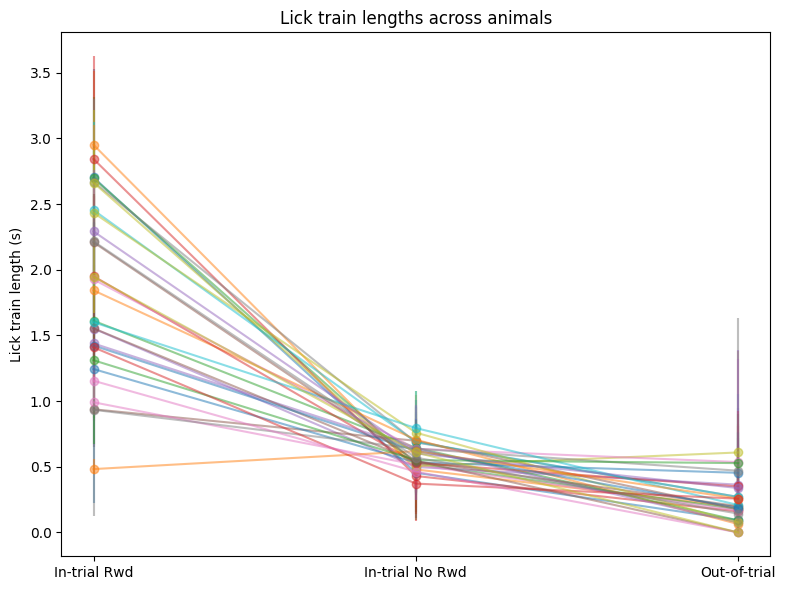

In [5]:
len_out_mean_ani_combined = [np.mean(result['combined']['out_of_trial']['len_mean']) for result in all_results]
len_in_rwd_mean_ani_combined = [np.mean(result['combined']['in_trial_rwd']['len_mean']) for result in all_results]
len_in_nrwd_mean_ani_combined = [np.mean(result['combined']['in_trial_no_rwd']['len_mean']) for result in all_results]

quantiles_out_ani_combined = [result['combined']['out_of_trial']['quantiles'] for result in all_results]
quantiles_in_rwd_ani_combined = [result['combined']['in_trial_rwd']['quantiles'] for result in all_results]
quantiles_in_nrwd_ani_combined = [result['combined']['in_trial_no_rwd']['quantiles'] for result in all_results]

# for all animal error bar plot for rwd - nrwd - out, mean, 25, 50, 75 quantiles, each animal has one line
fig = plt.figure(figsize=(8,6))
x = range(3)
for ani_ind in range(len(len_in_nrwd_mean_ani_combined)):
    means = [len_in_rwd_mean_ani_combined[ani_ind], len_in_nrwd_mean_ani_combined[ani_ind], len_out_mean_ani_combined[ani_ind]]
    q25 = [quantiles_in_rwd_ani_combined[ani_ind][0], quantiles_in_nrwd_ani_combined[ani_ind][0], quantiles_out_ani_combined[ani_ind][0]]
    q50 = [quantiles_in_rwd_ani_combined[ani_ind][1], quantiles_in_nrwd_ani_combined[ani_ind][1], quantiles_out_ani_combined[ani_ind][1]]
    q75 = [quantiles_in_rwd_ani_combined[ani_ind][2], quantiles_in_nrwd_ani_combined[ani_ind][2], quantiles_out_ani_combined[ani_ind][2]]
    plt.errorbar(x, q50, yerr=[np.array(q50) - np.array(q25), np.array(q75) - np.array(q50)], fmt='-o', alpha=0.5)
plt.xticks(x, ['In-trial Rwd', 'In-trial No Rwd', 'Out-of-trial'])
plt.ylabel('Lick train length (s)')
plt.title('Lick train lengths across animals')
plt.tight_layout()
# plt.savefig('/root/capsule/scratch/combined_lick_train_lengths_across_animals.pdf', dpi=300)

In [65]:
# plot ratios.
variables_collect = ['in_out_ratio', 'rl_ratio_out', 'rl_ratio_in', 'rl_ratio_outvsin', 'session_ids', 'rl_ratio_choice', 'rl_ratio_in_reward_choices']
lick_stats_df = pd.DataFrame()
for result in all_results:
    lick_stats_dict = {var: result[var] for var in variables_collect}
    lick_stats_df_curr = pd.DataFrame(lick_stats_dict)
    lick_stats_df = pd.concat([lick_stats_df, lick_stats_df_curr], ignore_index=True)
lick_stats_df['ratio_diff_abs'] = np.abs(lick_stats_df['rl_ratio_out'] - lick_stats_df['rl_ratio_in'])
lick_stats_df['ratio_diff_rwd_abs'] = np.abs(lick_stats_df['rl_ratio_out'] - lick_stats_df['rl_ratio_in_reward_choices'])
variables_collect.append('ratio_diff_abs')
variables_collect.append('ratio_diff_rwd_abs')

dict_keys(['in_out_ratio', 'rl_ratio_out', 'rl_ratio_in', 'rl_ratio_outvsin', 'session_ids', 'rl_ratio_choice', 'rl_ratio_in_reward_choices'])

Text(0.5, 1.0, 'Lick ratio reward vs Out across animals\n Pearson r=0.39, p=0.000')

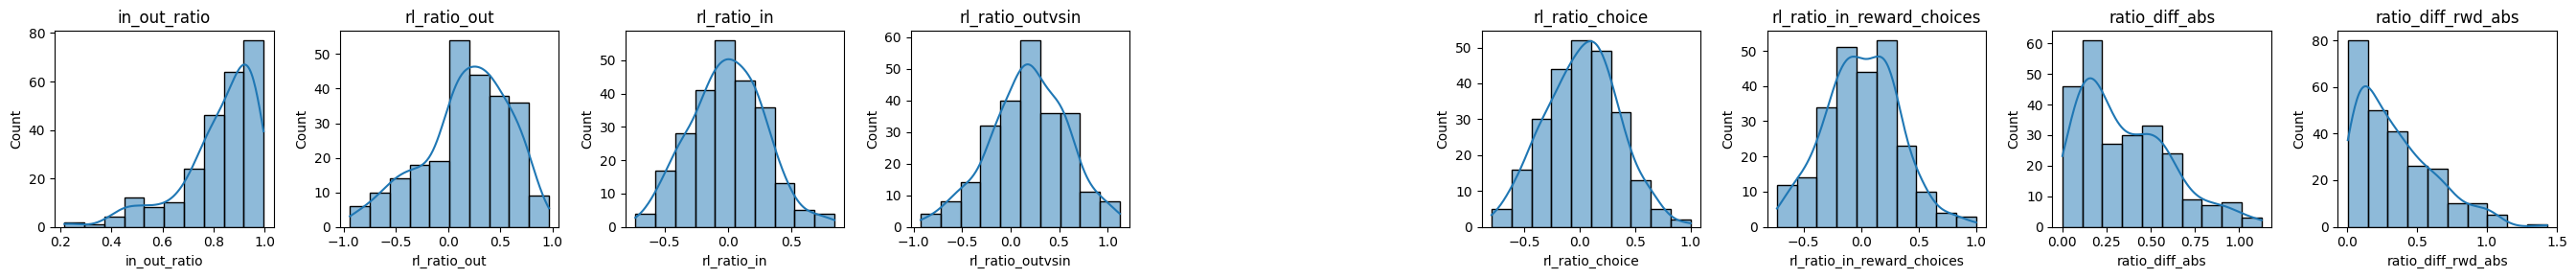

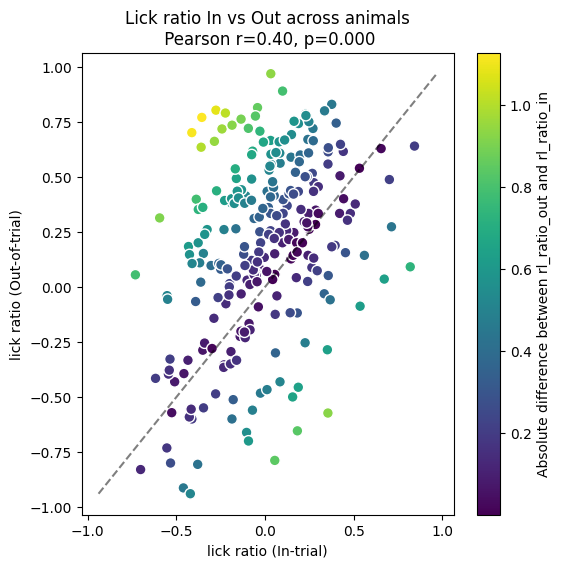

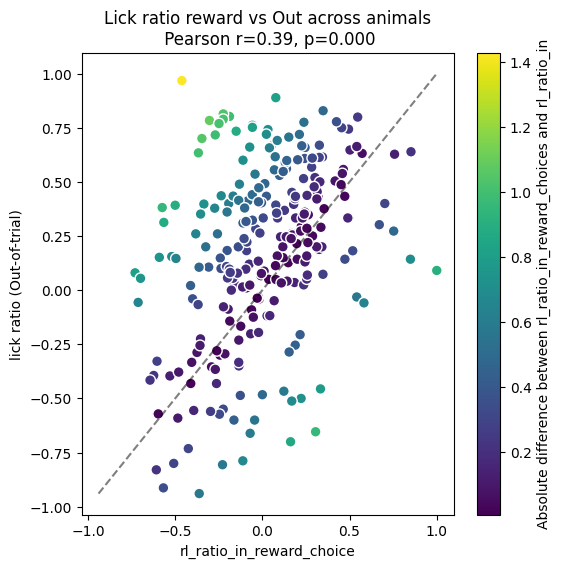

In [74]:
# plot histogram distribution of all of them
fig = plt.figure(figsize=(3*len(lick_stats_df.columns), 3))
gs = gridspec.GridSpec(1, len(variables_collect))
for i, var in enumerate(lick_stats_df.columns):
    # if numeric
    if lick_stats_df[var].dtype == 'O':
        continue
    ax = fig.add_subplot(gs[0, i])
    sns.histplot(lick_stats_df[var], ax=ax, kde=True, bins=10)
    ax.set_title(var)
plt.tight_layout()

# rl ratio out vs in across animals
fig = plt.figure(figsize=(6,6))
g = plt.scatter(lick_stats_df['rl_ratio_in'], lick_stats_df['rl_ratio_out'], alpha=1, s = 60, c=lick_stats_df['ratio_diff_abs'], cmap='viridis', edgecolor= 'w')
# add diagnonal line
min_v = min(lick_stats_df['rl_ratio_in'].min(), lick_stats_df['rl_ratio_out'].min())
max_v = max(lick_stats_df['rl_ratio_in'].max(), lick_stats_df['rl_ratio_out'].max())
plt.plot([min_v, max_v], [min_v, max_v], 'k--', alpha=0.5)
# colorbar
plt.colorbar(g, label='Absolute difference between rl_ratio_out and rl_ratio_in')
# correlation and p values
corr, p_value = stats.pearsonr(lick_stats_df['rl_ratio_in'], lick_stats_df['rl_ratio_out'])
plt.xlabel('lick ratio (In-trial)')
plt.ylabel('lick ratio (Out-of-trial)')
plt.title(f'Lick ratio In vs Out across animals\n Pearson r={corr:.2f}, p={p_value:.3f}')

fig = plt.figure(figsize=(6,6))
g = plt.scatter(lick_stats_df['rl_ratio_in_reward_choices'], lick_stats_df['rl_ratio_out'], alpha=1, s = 60, c=lick_stats_df['ratio_diff_rwd_abs'], cmap='viridis', edgecolor= 'w')
# correlation and p values
min_v = min(lick_stats_df['rl_ratio_in_reward_choices'].min(), lick_stats_df['rl_ratio_out'].min())
max_v = max(lick_stats_df['rl_ratio_in_reward_choices'].max(), lick_stats_df['rl_ratio_out'].max())
plt.plot([min_v, max_v], [min_v, max_v], 'k--', alpha=0.5)
plt.colorbar(g, label='Absolute difference between rl_ratio_in_reward_choices and rl_ratio_in')
corr, p_value = stats.pearsonr(lick_stats_df['rl_ratio_in_reward_choices'], lick_stats_df['rl_ratio_out'])
plt.xlabel('rl_ratio_in_reward_choice')
plt.ylabel('lick ratio (Out-of-trial)')
plt.title(f'Lick ratio reward vs Out across animals\n Pearson r={corr:.2f}, p={p_value:.3f}')

Text(0.5, 1.0, 'Correlation\n Pearson r=-0.29, p=0.000')

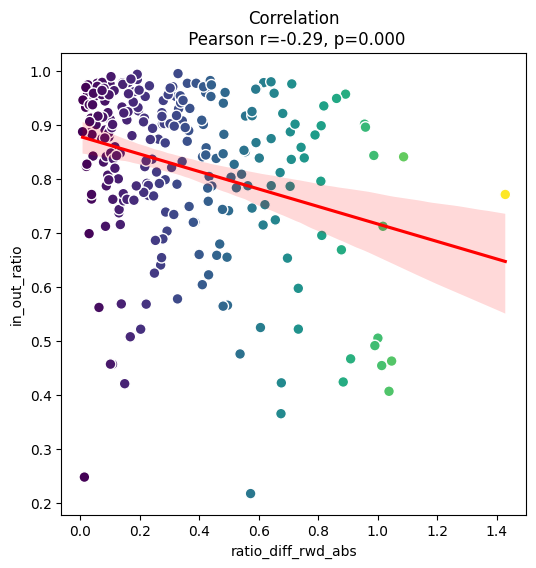

In [77]:
fig = plt.figure(figsize=(6,6))
x = 'ratio_diff_rwd_abs'
y = 'in_out_ratio'
plt.scatter(lick_stats_df[x], lick_stats_df[y], alpha=1, s = 60, c = lick_stats_df[x], cmap='viridis', edgecolor= 'w')
# add regression line and confidence interval
sns.regplot(x=lick_stats_df[x], y=lick_stats_df[y], scatter=False, ax=plt.gca(), line_kws={'color': 'red'})
# correlation and p values
corr, p_value = stats.pearsonr(lick_stats_df[x], lick_stats_df[y])
plt.xlabel(x)
plt.ylabel(y)
plt.title(f'Correlation\n Pearson r={corr:.2f}, p={p_value:.3f}')

In [19]:
# load all model results into a list
fit_values = {'post': [], 'pre': [], 'iti': [], 'side_post': [], 'side_pre': [], 'side_iti': []}
for result in all_results_model:
    animal_id = result['animal_id']
    for key in fit_values.keys():
        lm_key = 'lm_' + key
        lm = result[lm_key]
        if lm is not None:
            if key.startswith('side'):
                z_vals = lm.tvalues
                p_vals = lm.pvalues
            else:
                z_vals = lm.tvalues[1:]
                p_vals = lm.pvalues[1:]
            curr_df = pd.DataFrame({'animal_id': animal_id, 'regressor': z_vals.index, 'z_value': z_vals.values, 'model': key, 'p_value': p_vals.values})
            fit_values[key].append(curr_df)
# combine each field into one dataframe
for key in fit_values.keys():
    if len(fit_values[key]) > 0:
        fit_values[key] = pd.concat(fit_values[key])
    else:
        print(f'No model fits for {key}')




/tmp/ipykernel_1518152/288793720.py:22: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


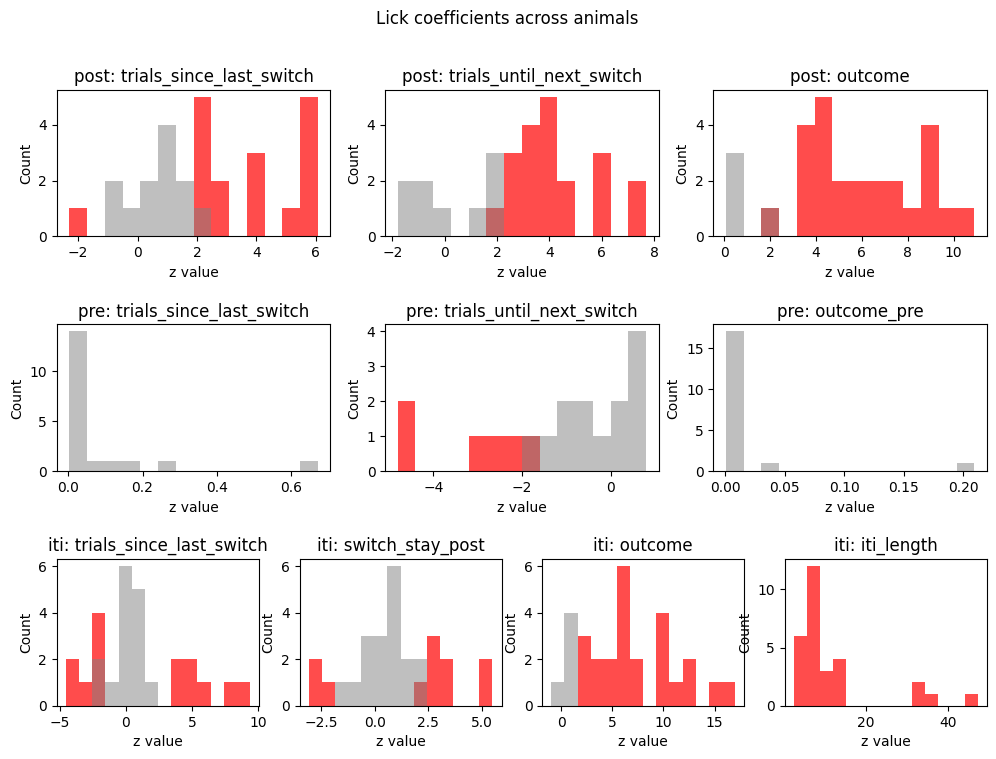

In [37]:
# plot model z values across animals as histograms
# each row is a model (post, pre, iti), each column is a regressor
fig = plt.figure(figsize=(12,8))
model_keys = ['post', 'pre', 'iti']
for row_ind, model_key in enumerate(model_keys):
    model_df = fit_values[model_key]
    regressors = model_df['regressor'].unique().tolist()
    for col_ind, regressor in enumerate(regressors):
        ax = fig.add_subplot(len(model_keys), len(regressors), row_ind*len(regressors) + col_ind + 1)
        reg_df = model_df[model_df['regressor'] == regressor]
        # significant in red, non-significant in gray
        sig_mask = reg_df['p_value'] < 0.05
        bin_edges = np.linspace(np.min(reg_df['z_value']), np.max(reg_df['z_value']), 15)
        ax.hist(reg_df[sig_mask]['z_value'], bins=bin_edges, color='r', alpha=0.7, label='p < 0.05')
        ax.hist(reg_df[~sig_mask]['z_value'], bins=bin_edges, color='gray', alpha=0.5, label='p >= 0.05')

        ax.set_title(f'{model_key}: {regressor}')
        ax.set_xlabel('z value')
        ax.set_ylabel('Count')
plt.suptitle('Lick coefficients across animals')
fig.subplots_adjust(hspace=0.6)
plt.tight_layout()

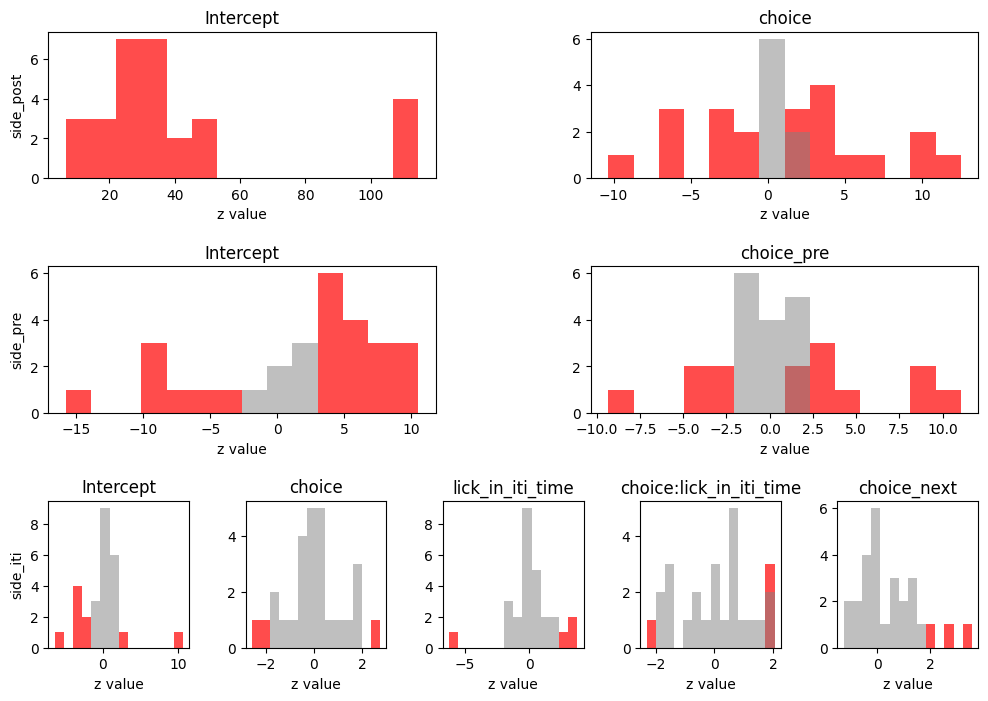

In [38]:
model_keys = ['side_post', 'side_pre', 'side_iti']
fig = plt.figure(figsize=(12,8))
for row_ind, model_key in enumerate(model_keys):
    model_df = fit_values[model_key]
    regressors = model_df['regressor'].unique().tolist()
    for col_ind, regressor in enumerate(regressors):
        ax = fig.add_subplot(len(model_keys), len(regressors), row_ind*len(regressors) + col_ind + 1)
        reg_df = model_df[model_df['regressor'] == regressor]
        # significant in red, non-significant in gray
        sig_mask = reg_df['p_value'] < 0.05
        bin_edges = np.linspace(np.min(reg_df['z_value']), np.max(reg_df['z_value']), 15)
        ax.hist(reg_df[sig_mask]['z_value'], bins=bin_edges, color='r', alpha=0.7, label='p < 0.05')
        ax.hist(reg_df[~sig_mask]['z_value'], bins=bin_edges, color='gray', alpha=0.5, label='p >= 0.05')

        ax.set_title(f'{regressor}')
        ax.set_xlabel('z value')
        if col_ind == 0:
            ax.set_ylabel(model_key)
fig.subplots_adjust(hspace=0.6, wspace=0.4)

In [22]:
# flatten all keys and pair plot all regressors
all_model_df_spont_lick_df = pd.DataFrame()
for key in fit_values.keys():
    curr_df = fit_values[key].copy()
    # append key to regressor name
    curr_df['regressor'] = key + '_model_' + curr_df['regressor']
    all_model_df_spont_lick_df = pd.concat([all_model_df_spont_lick_df, curr_df])
# group by regressors as columns an animal id as rows
model_df_wide = all_model_df_spont_lick_df.pivot(index='animal_id', columns='regressor', values='z_value')
model_df_sig_wide = all_model_df_spont_lick_df.pivot(index='animal_id', columns='regressor', values='p_value') < 0.05

In [23]:
# custom scatter plot with significant points on xaxis red
# import pearsonr
from scipy.stats import pearsonr
def custom_pair_plot(model_df_wide, model_df_sig_wide):
    regressors = model_df_wide.columns.tolist()
    fig = plt.figure(figsize=(3*len(regressors), 3*len(regressors)))
    for i in range(len(regressors)):
        for j in range(len(regressors)):
            if i != j:
                ax = fig.add_subplot(len(regressors), len(regressors), j*len(regressors) + i + 1)
                x = model_df_wide[regressors[i]]
                y = model_df_wide[regressors[j]]
                sig_x = model_df_sig_wide[regressors[i]]
                ax.scatter(x[~sig_x], y[~sig_x], color='gray', alpha=0.5, label='p >= 0.05', edgecolors='w',s = 40)
                ax.scatter(x[sig_x], y[sig_x], color='r', alpha=0.7, label='p < 0.05', edgecolors='w',s = 40)
                ax.set_xlabel(regressors[i])
                ax.set_ylabel(regressors[j])
                # correlation and p value
                valid_ind = ~model_df_sig_wide[regressors[i]].isna() & ~model_df_sig_wide[regressors[j]].isna()
                if np.sum(valid_ind) > 1:
                    corr, p_val = pearsonr(x[valid_ind], y[valid_ind])
                    if p_val < 0.05:
                        ax.set_title(f'p={p_val:.3f}', color='r')
                    else:
                        ax.set_title(f'p={p_val:.3f}', color='gray')

            elif i==j:
                # histogram on the diagonal for gray non-significant, red significant
                edges = np.linspace(np.nanmin(model_df_wide[regressors[i]]), np.nanmax(model_df_wide[regressors[i]]), 15)
                ax = fig.add_subplot(len(regressors), len(regressors), i*len(regressors) + j + 1)
                sig_mask = model_df_sig_wide[regressors[i]]
                ax.hist(model_df_wide[regressors[i]][~sig_mask], bins=edges, color='gray', alpha=0.5, label='p >= 0.05')
                ax.hist(model_df_wide[regressors[i]][sig_mask], bins=edges, color='r', alpha=0.7, label='p < 0.05')
                ax.set_xlabel(regressors[i])
                ax.set_ylabel('Count')
    plt.tight_layout()
    return fig

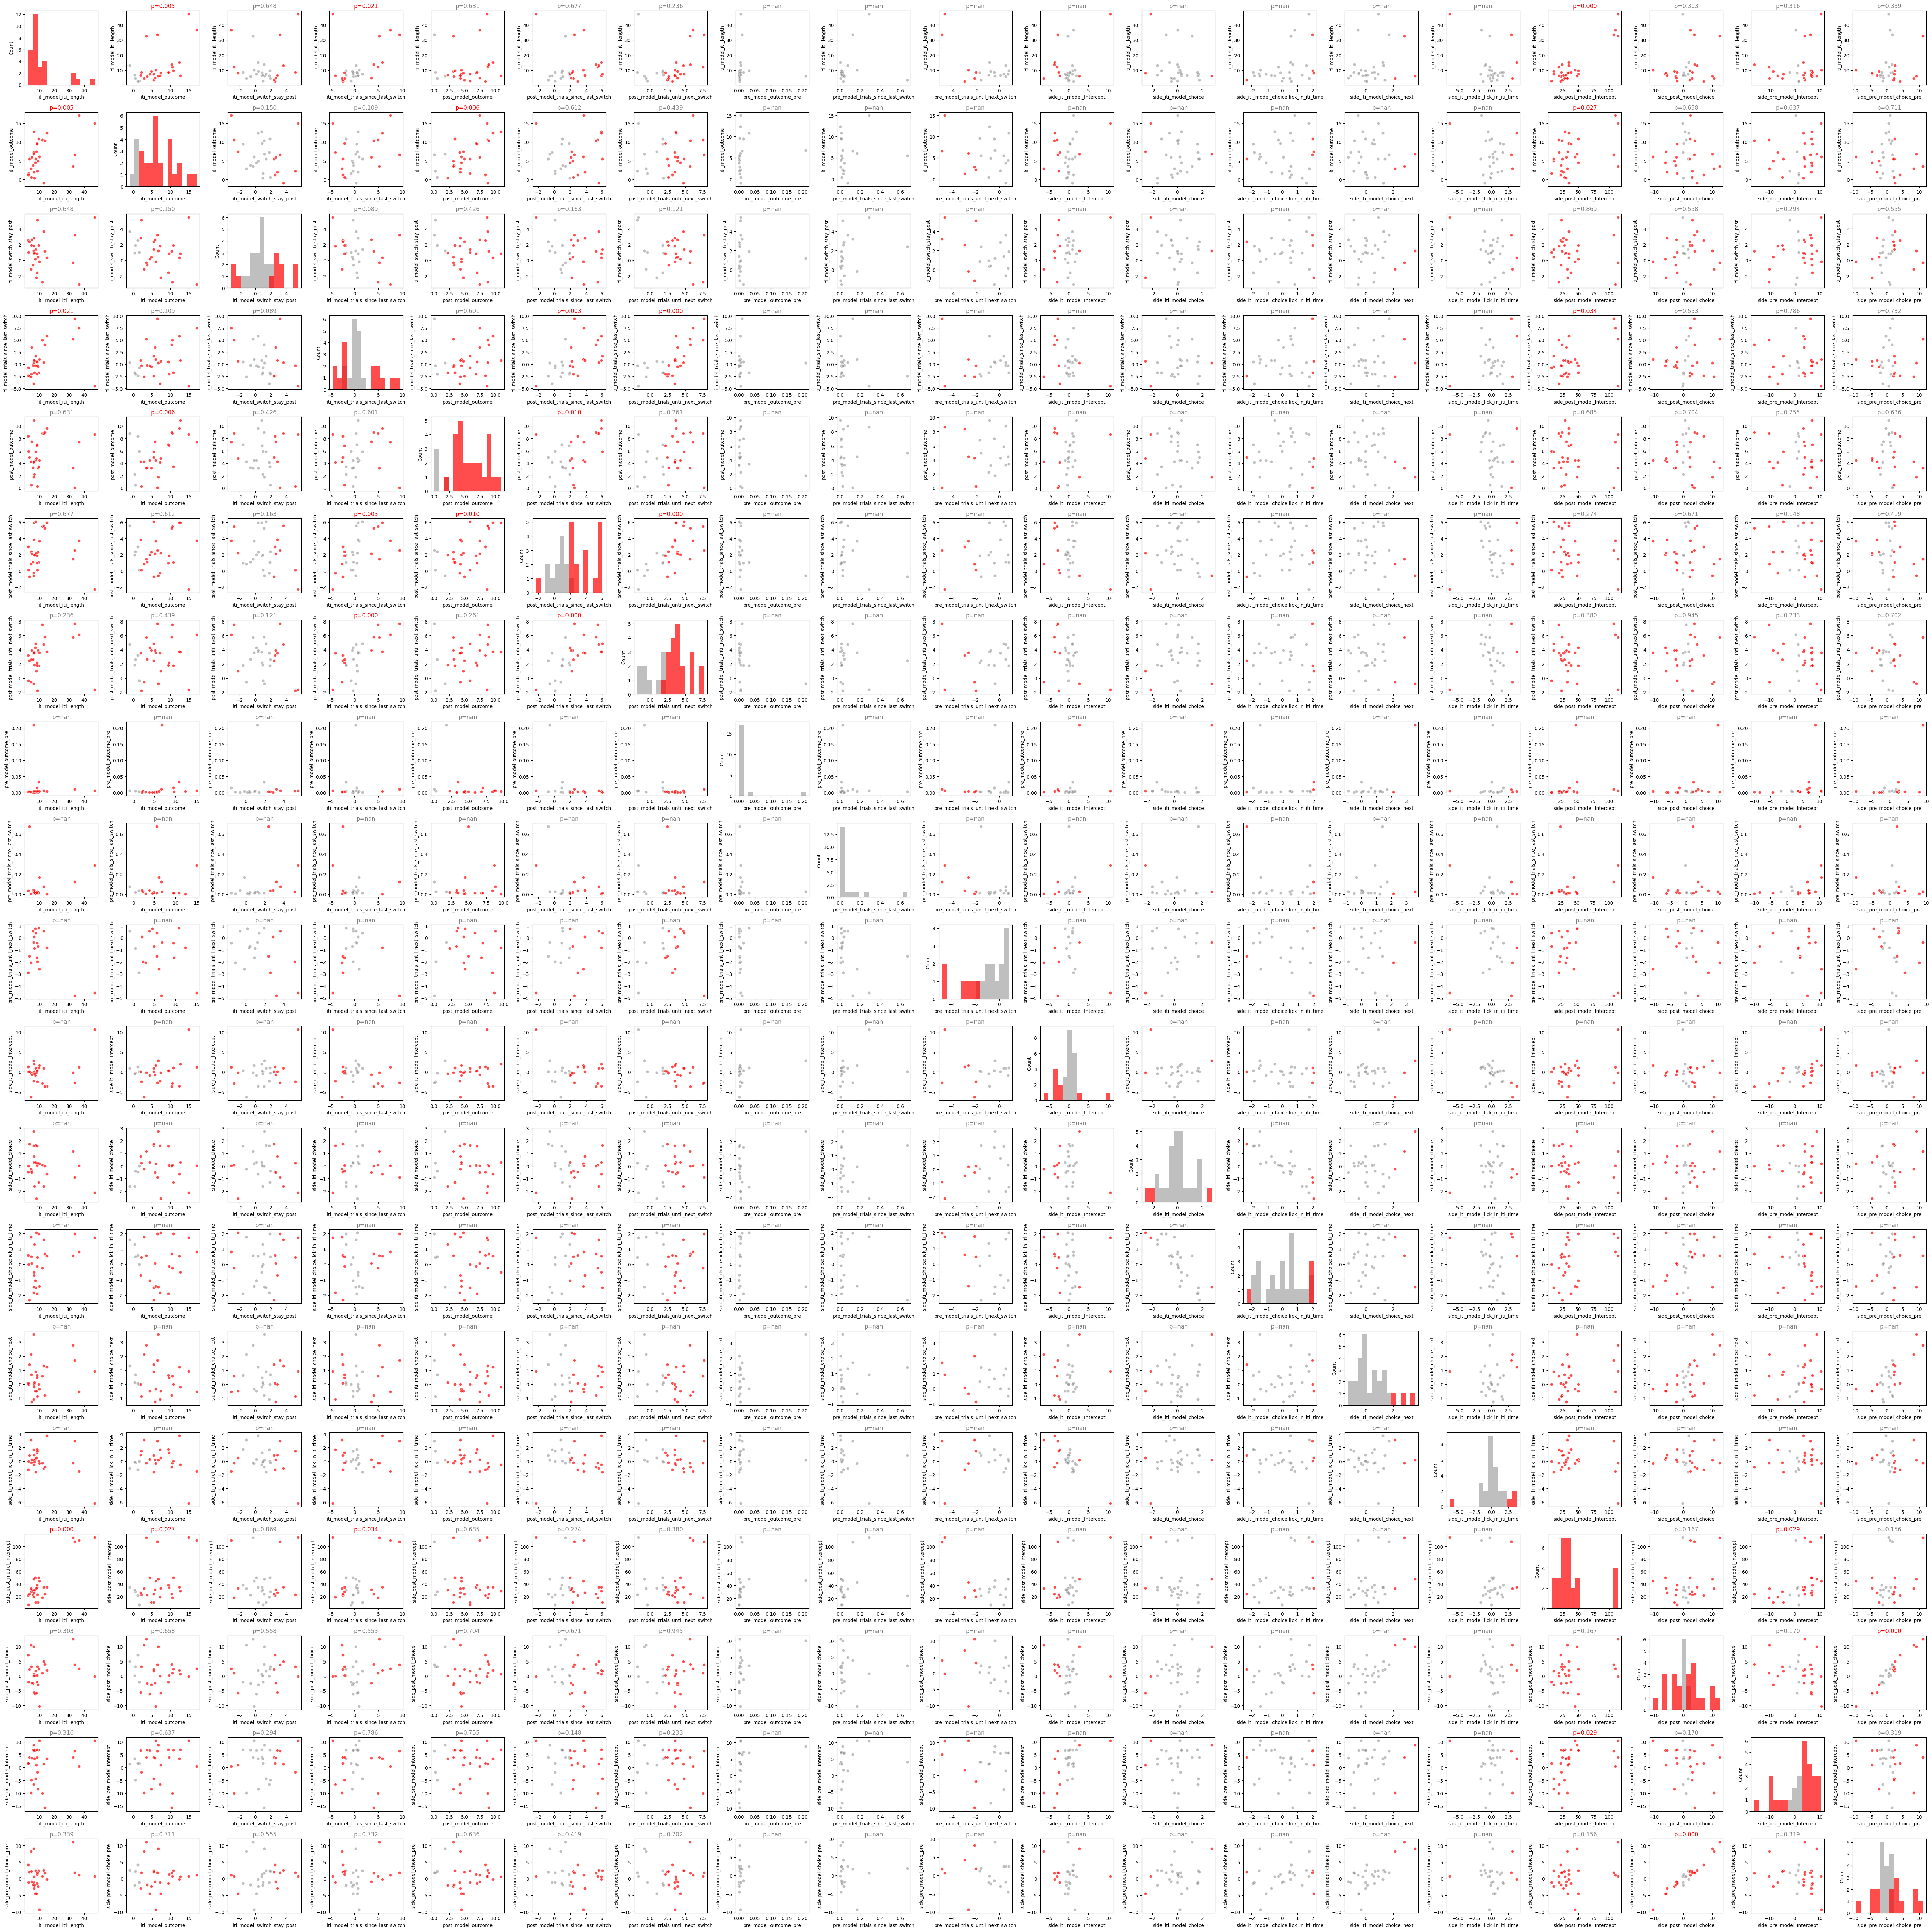

In [24]:
fig = custom_pair_plot(model_df_wide, model_df_sig_wide)
fig.savefig(fname=os.path.join(target_folder, f'lick_in_trial_model_pairplot_video_{video}.png'), dpi=300)

In [25]:
# gather behavior data for pair plot
# merge with behavior 
with open(os.path.join('/root/capsule/scratch/combined/combined_session_tbl', 'combined_beh_sessions.pkl'), 'rb') as f:
    combined_session_qc = pickle.load(f)
combined_session_qc.drop(columns=['probe'], inplace=True, errors='ignore')
combined_session_qc.loc[combined_session_qc['p_st_w']==1, 'diff_1'] = 5

In [30]:
lick_model_behavior_df['ani_id']

0     716325
1     717121
2     751004
3     751181
4     751766
5     751769
6     752014
7     754897
8     758017
9     758018
10    761038
11    763590
12    781166
13    782394
14    784803
15    784806
16    785956
17    791691
18     ZS059
19     ZS060
20     ZS061
21     ZS062
Name: ani_id, dtype: object

In [31]:
combined_session_qc['ani_id'] = [parseSessionID(session)[0] for session in combined_session_qc['session']]
# gather all numeric columns and compute mean per animal
numeric_cols = combined_session_qc.select_dtypes(include=[np.number]).columns.tolist()
ani_behavior_means = combined_session_qc.groupby('ani_id')[numeric_cols].mean().reset_index()
# combined to model_df_wide
lick_model_behavior_df = pd.merge(model_df_wide, ani_behavior_means, left_on='animal_id', right_on='ani_id')
lick_model_behavior_df = pd.merge(lick_model_behavior_df, lick_stats_df, left_on='ani_id', right_on='animal_id')

KeyboardInterrupt: 

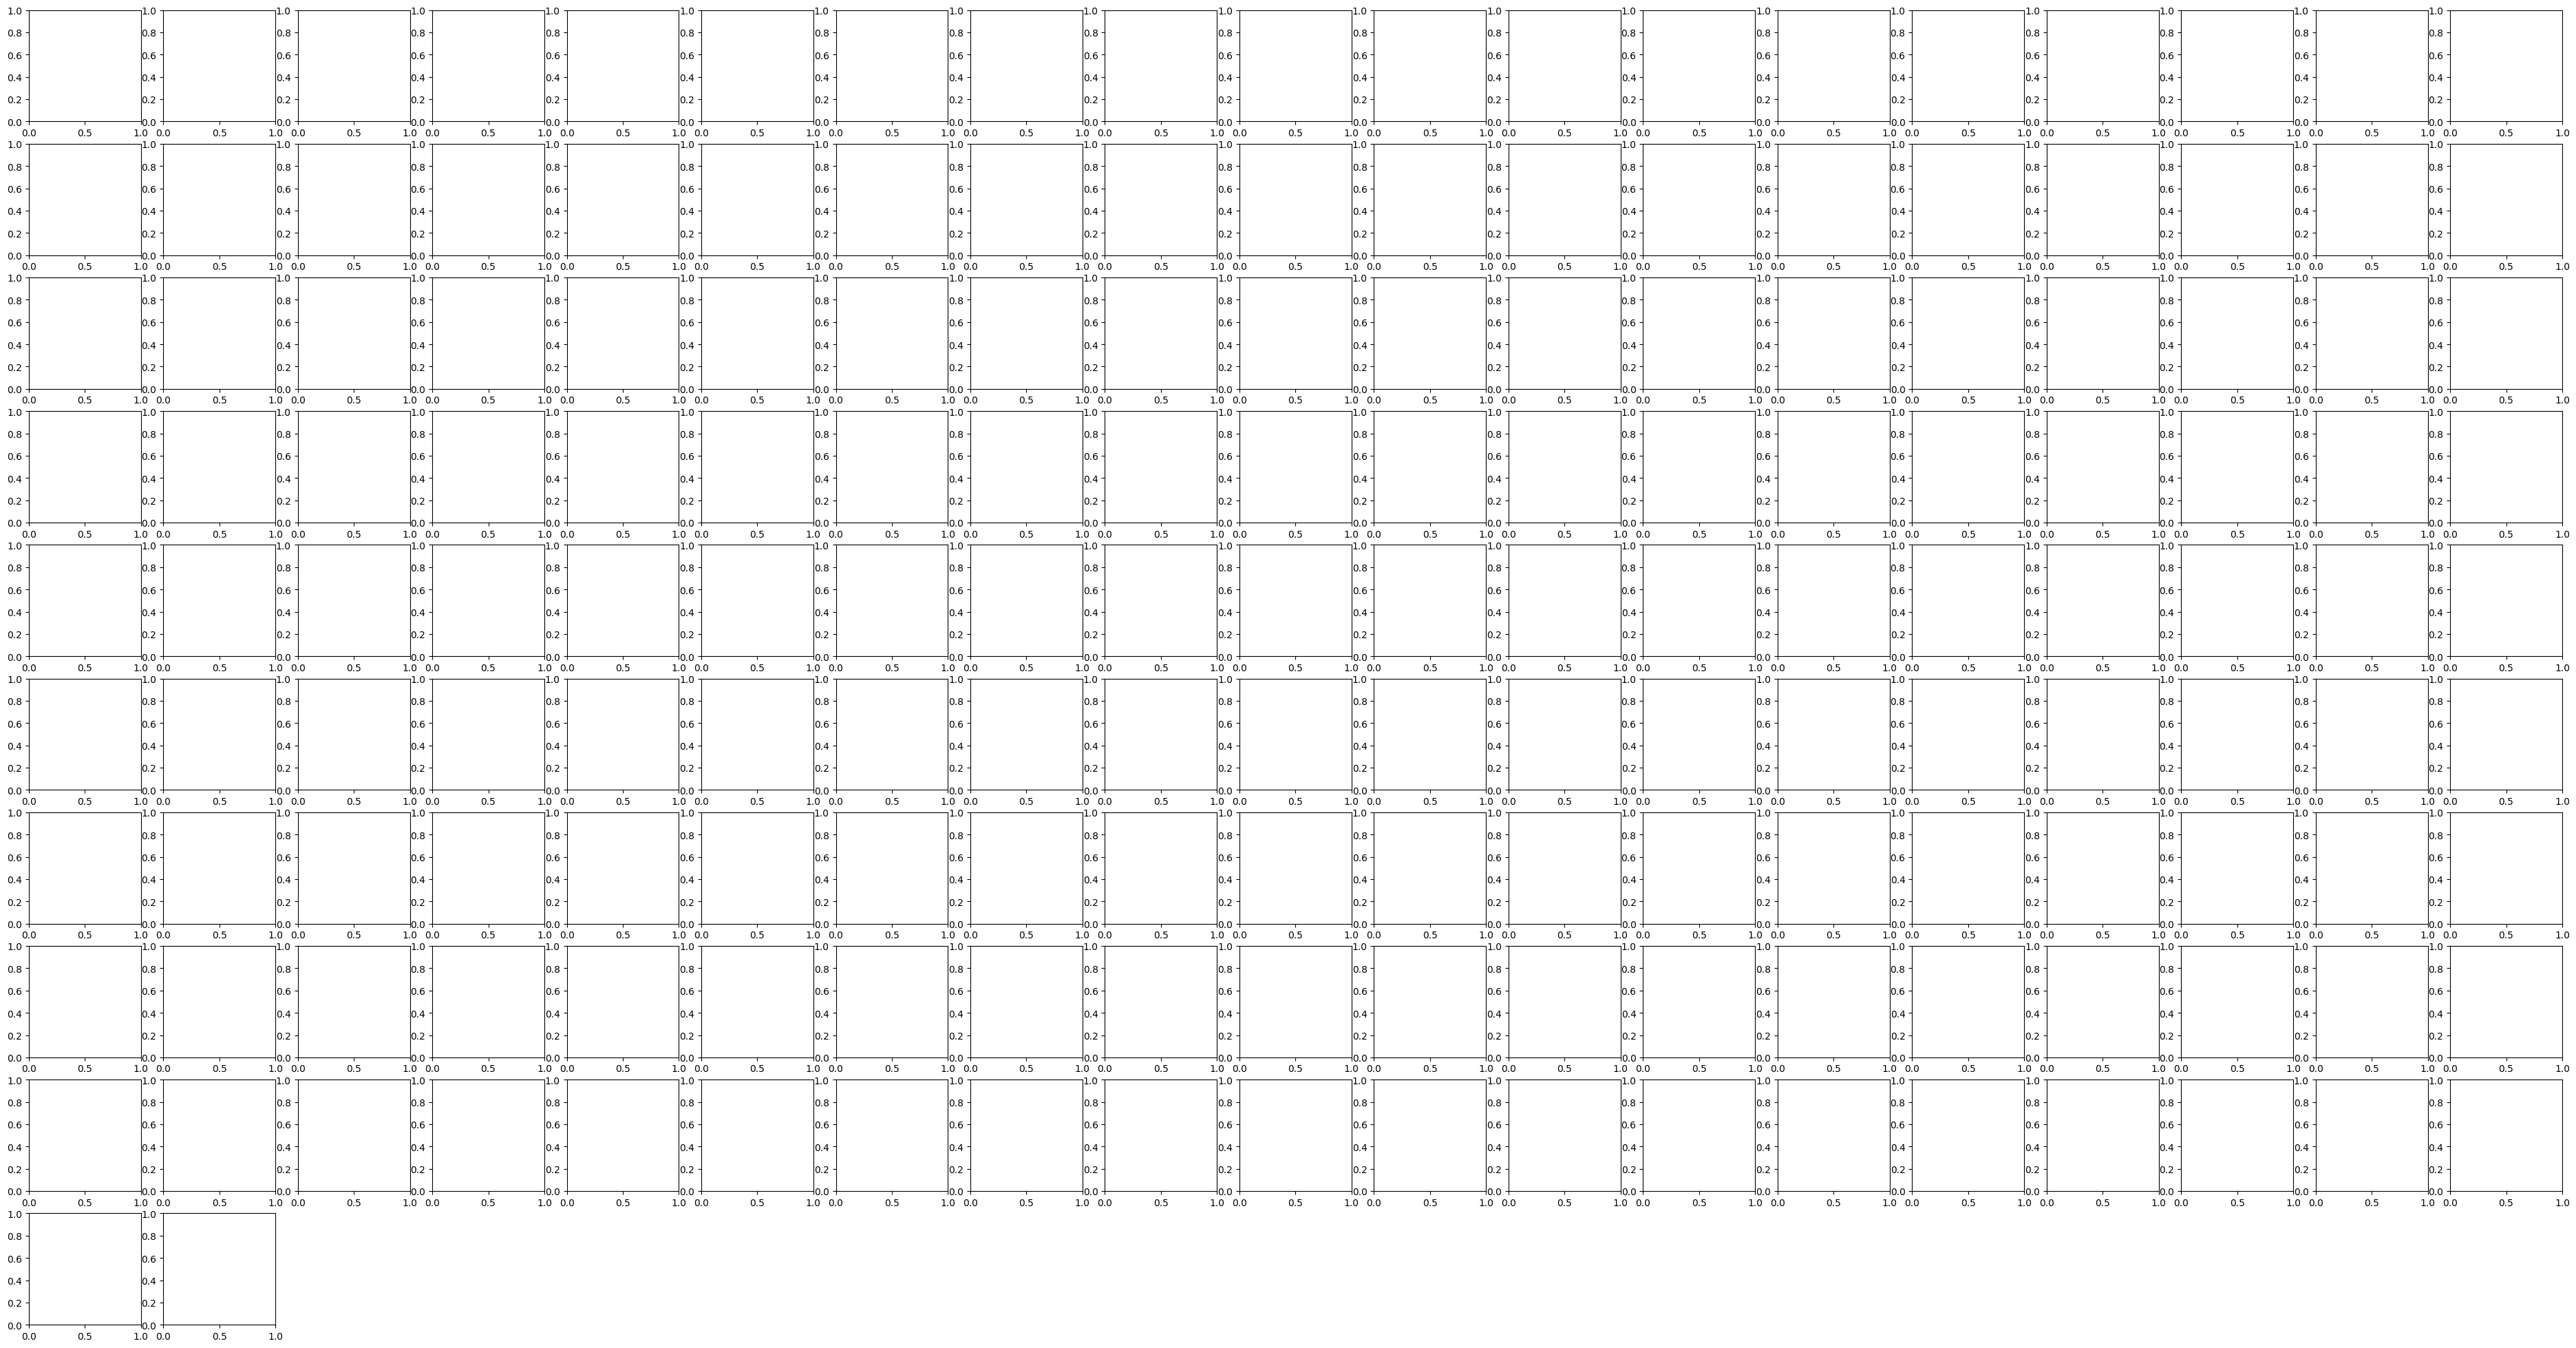

In [33]:
# pairplot with color code from behavior metrics
beh_metrics = ani_behavior_means.columns.tolist()[1:]
beh_metrics = ['sw_bias',
                'rwd_1',
                'p_sw',
                'nrwd_1',
                'intercept',
                'diff_1',
                'beta',
                'aN']
cols_pairplot = model_df_wide.columns.tolist()
for metric in beh_metrics:
    pairplot_color_code = lick_model_behavior_df[metric].values
    valid_ind = np.isnan(pairplot_color_code)
    # rank
    pairplot_color_code_nl = np.full(len(lick_model_behavior_df), np.nan)
    pairplot_color_code_nl[~valid_ind] = np.argsort(pairplot_color_code[~valid_ind])
    pairplot_df = lick_model_behavior_df[cols_pairplot].copy()
    pairplot_df['color_code'] = pairplot_color_code_nl
    g = sns.pairplot(pairplot_df, hue='color_code', diag_kind='hist', plot_kws={'alpha':0.7}, diag_kws={'alpha':0.5}, corner=True)
    g.fig.suptitle(f'Lick model coefficients colored by {metric}', y=1.02)
    g.savefig(fname=os.path.join(target_folder, f'lick_model_pairplot_colored_{metric}_video_{video}.png'), dpi=100)

In [ ]:
# pairplot with color code from behavior metrics
lick_metrics = model_df_wide.columns.tolist()
cols_pairplot = ani_behavior_means.columns.tolist()
cols_pairplot = ['sw_bias',
                'rwd_1',
                'p_sw',
                'nrwd_1',
                'intercept',
                'diff_1',
                'beta',
                'aN']
for metric in lick_metrics:
    pairplot_color_code = lick_model_behavior_df[metric].values
    valid_ind = np.isnan(pairplot_color_code)
    # rank
    pairplot_color_code_nl = np.full(len(lick_model_behavior_df), np.nan)
    pairplot_color_code_nl[~valid_ind] = np.argsort(pairplot_color_code[~valid_ind])
    pairplot_df = lick_model_behavior_df[cols_pairplot].copy()
    pairplot_df['color_code'] = pairplot_color_code_nl
    g = sns.pairplot(pairplot_df, hue='color_code', diag_kind='hist', plot_kws={'alpha':0.7}, diag_kws={'alpha':0.5}, corner=True)
    g.fig.suptitle(f'Lick model coefficients colored by {metric}', y=1.02)
    g.savefig(fname=os.path.join(target_folder, f'beh_model_pairplot_colored_{metric}_video_{video}.png'), dpi=100)

In [34]:
lick_stats_df.columns

Index(['rl_ratio_out', 'rl_ratio_in', 'rl_ratio_outvsin', 'session_ids',
       'in_out_ratio_mean', 'animal_id'],
      dtype='object')

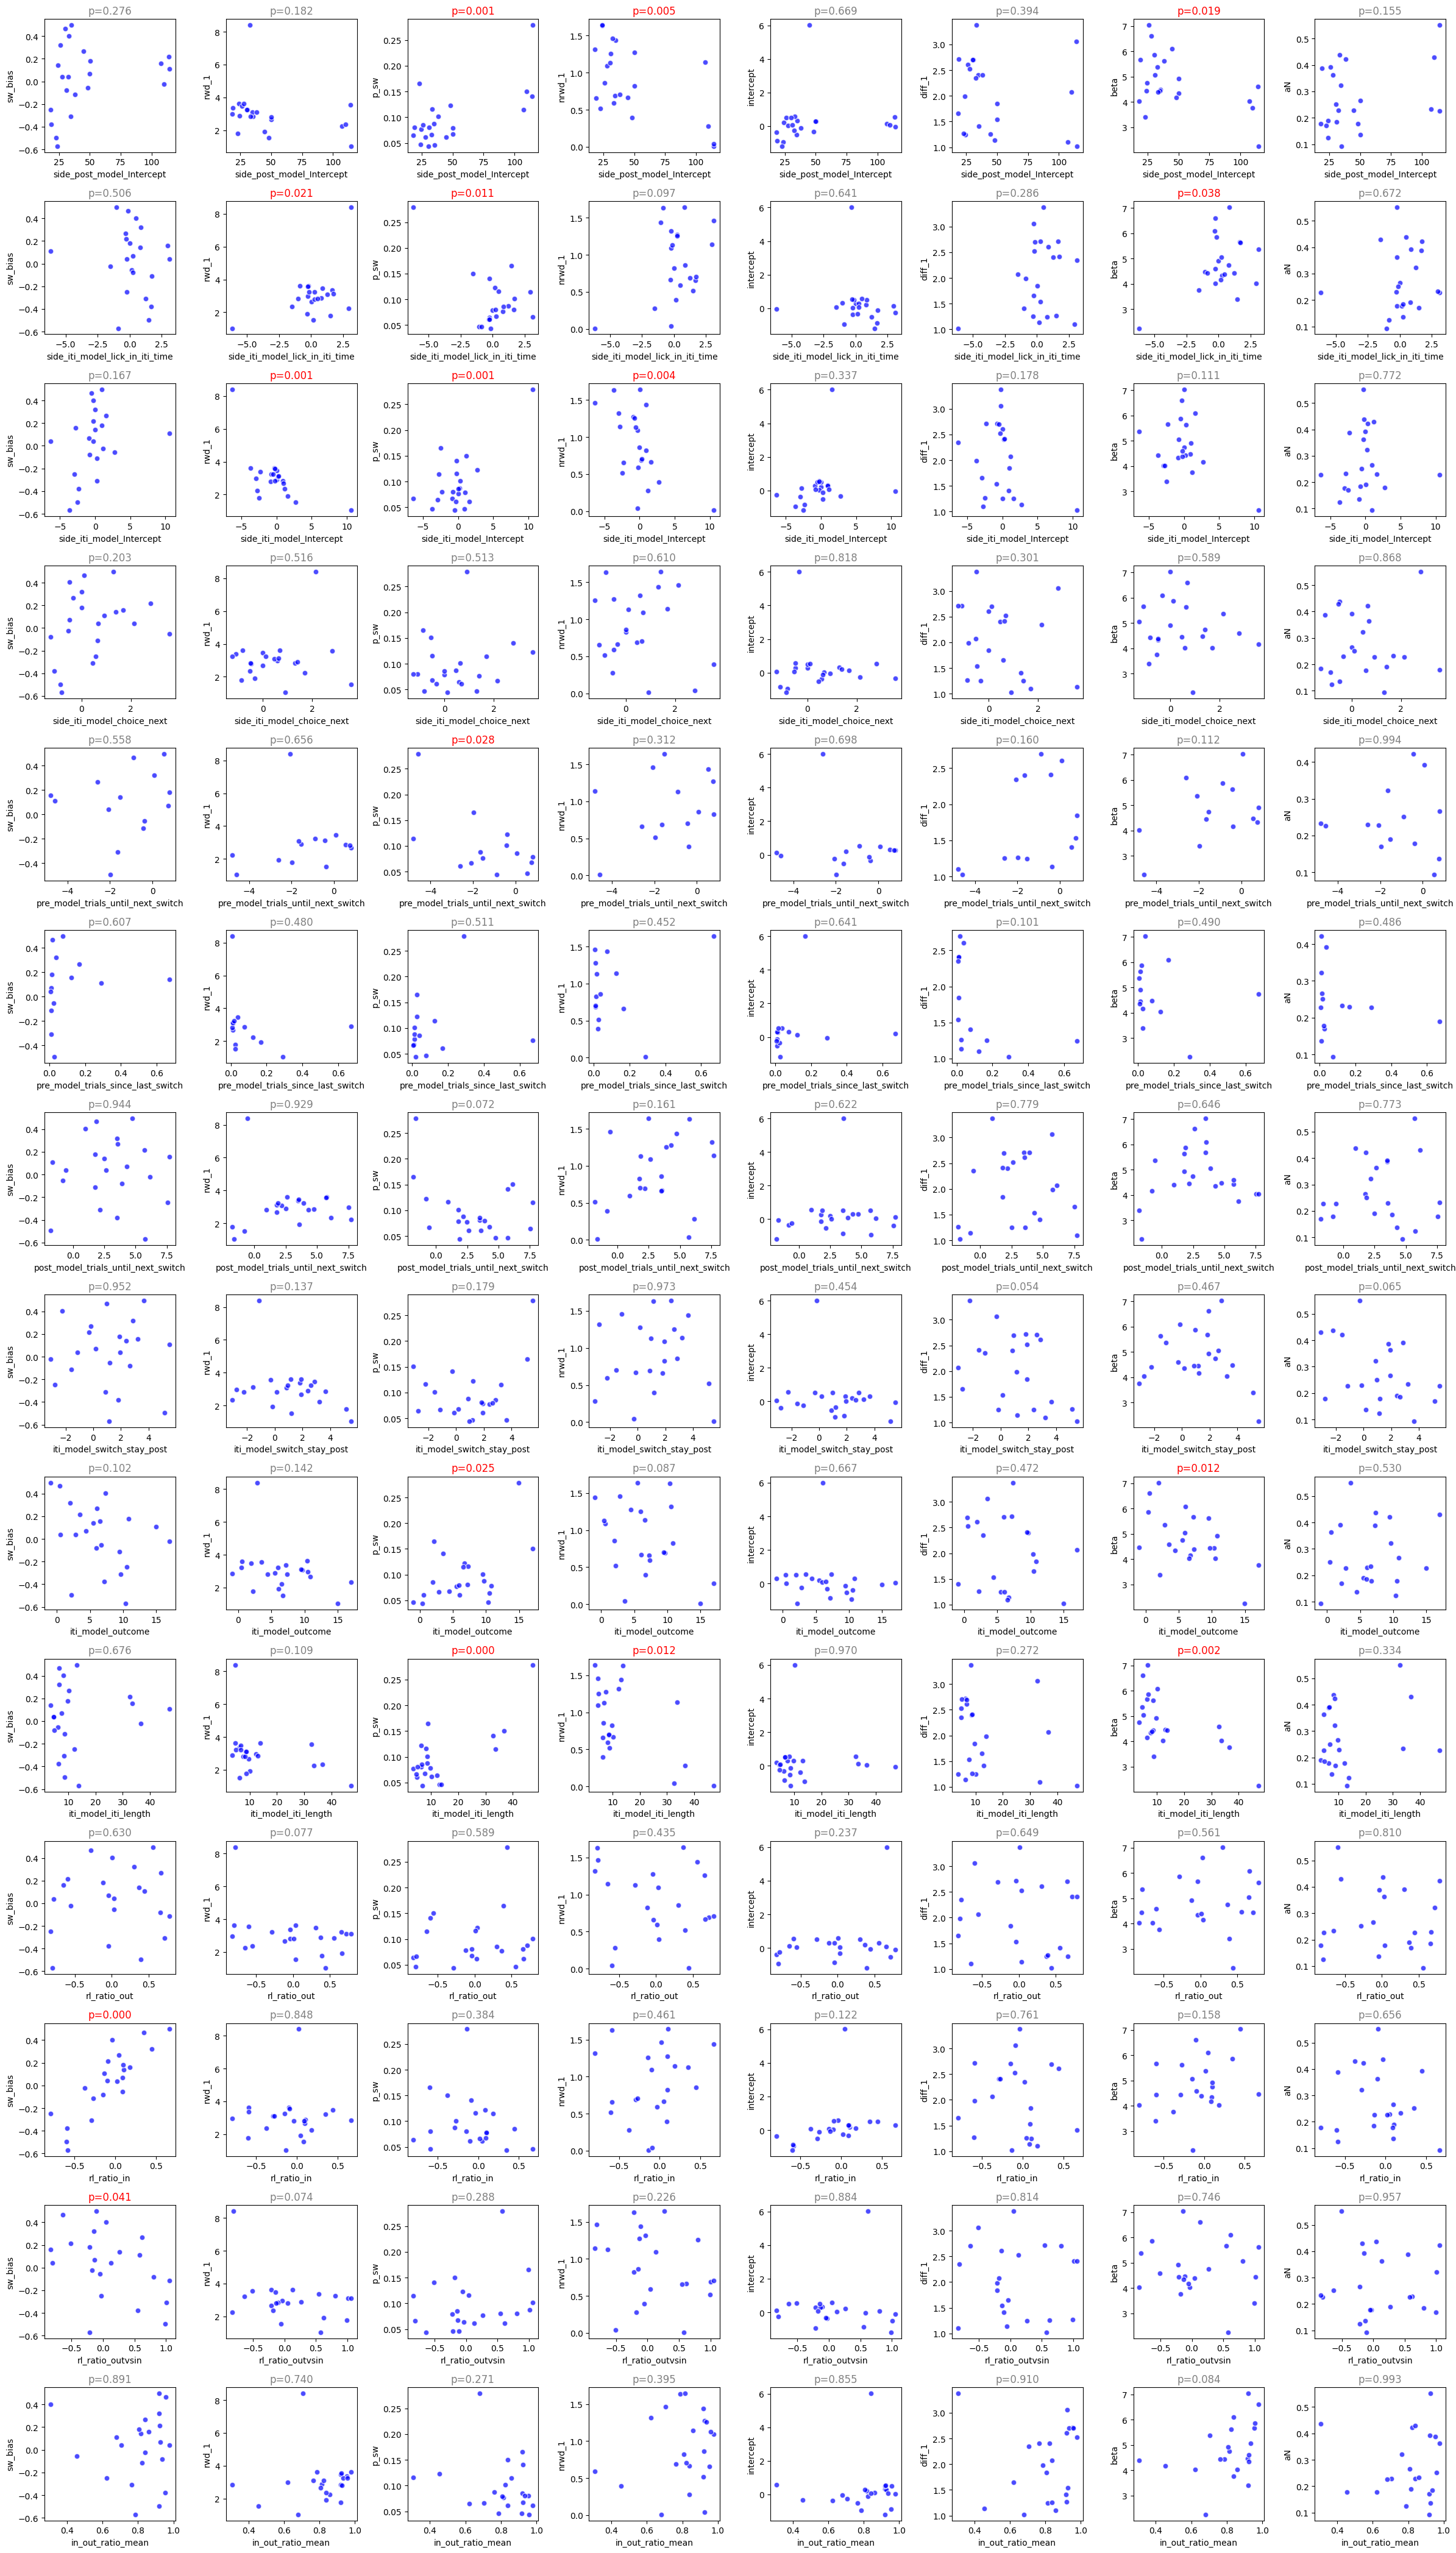

In [36]:
cols_beh_model = ['sw_bias',
                'rwd_1',
                'p_sw',
                'nrwd_1',
                'intercept',
                'diff_1',
                'beta',
                'aN']
cols_lick_model = ['side_post_model_Intercept',
                'side_iti_model_lick_in_iti_time',
                'side_iti_model_Intercept',
                'side_iti_model_choice_next',
                'pre_model_trials_until_next_switch',
                'pre_model_trials_since_last_switch',
                'post_model_trials_until_next_switch',
                'iti_model_switch_stay_post',
                'iti_model_outcome',
                'iti_model_iti_length',
                'rl_ratio_out', 'rl_ratio_in', 'rl_ratio_outvsin',
                'in_out_ratio_mean'
                ]

#scatter against each other
fig = plt.figure(figsize=(3*len(cols_beh_model), 3*len(cols_lick_model)))
for row_ind, lick_col in enumerate(cols_lick_model):
    for col_ind, beh_col in enumerate(cols_beh_model):
        ax = fig.add_subplot(len(cols_lick_model), len(cols_beh_model), row_ind*len(cols_beh_model) + col_ind + 1)
        x = lick_model_behavior_df[lick_col]
        y = lick_model_behavior_df[beh_col]
        ax.scatter(x, y, color='b', alpha=0.7, edgecolors='w',s = 40)
        ax.set_xlabel(lick_col)
        ax.set_ylabel(beh_col)
        # correlation and p value
        valid_ind = ~x.isna() & ~y.isna()
        if np.sum(valid_ind) > 1:
            corr, p_val = pearsonr(x[valid_ind], y[valid_ind])
            if p_val < 0.05:
                ax.set_title(f'p={p_val:.3f}', color='r')
            else:
                ax.set_title(f'p={p_val:.3f}', color='gray')
plt.tight_layout()
fig.savefig(fname=os.path.join(target_folder, f'combined_lick_model_beh_model_scatter_video_{video}.png'), dpi=300)

In [ ]:
ani_behavior_means.columns.tolist()[0]

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.hist(results['in_out_ratio'], bins = 40);
plt.title(f'Animal {animal_id} in-out lick ratio across {len(ani_list)} sessions')

In [ ]:
quantiles_in_nrwd_ani_combined[0]